The City of Philadelphia and its partners at Bicycle Transit Systems
---


 Prediction of length of trip (duration)
--

In [3]:
import pandas as pd
import numpy as np
np.random.seed(2017)

import glob
import pickle
import datetime
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold, GroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor



Curate and clean-up dataset, i.e., as a single data frame, entire data set and all quarters.
--

In [15]:
# Load raw data
path =r'/Users/melike/machinelearning/INDECO/Indeco_data'
allFiles = glob.glob(path + "/*.csv")
list_ = []

for file_ in allFiles:
    df = pd.read_csv(file_,index_col=None, header=0)
    
    #handle missing column
    df = df.replace('[]', np.nan)
    df = df.replace('...', np.nan)
    #df.replace('',-99999, inplace=True)
    modifiedFlights=df.fillna("...")
    modifiedFlights = df.dropna()
    modifiedFlights.isnull().sum()
    modifiedFlights.to_csv('modifiedFlights.csv',index=False)
    df=df.dropna()
    list_.append(df)
    #df.drop(to_drop, inplace=True, axis=1)
    
frame = pd.concat(list_)

/Users/melike/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
df.head()

,duration,start_date,start_year,start_month,start_hour,start_sn,weekday,start_city,end_city,subscription_type
0,0.300000,2018-01-01,2018,1,0,0,Monday,Race Street Pier,9th & Spring Garden,Indego30
1,9.533333,2018-01-01,2018,1,0,0,Monday,Rittenhouse Square,19th & Lombard,Indego365
2,0.366667,2018-01-01,2018,1,0,0,Monday,2nd & South,Rittenhouse Square,Indego30
3,0.350000,2018-01-01,2018,1,1,0,Monday,13th & Locust,Pennsylvania Convention Center,Indego30
4,0.066667,2018-01-01,2018,1,1,0,Monday,"19th & Girard, PTTI",20th & Fairmount,Indego30


Load Data
--
single file


In [8]:
df = pd.read_csv('indego-trips-2018-q2.csv', parse_dates=['start_time'])

In [10]:
df.head()

,trip_id,duration,start_time,end_time,start_station,start_lat,start_lon,end_station,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type
0,241475855,3,2018-04-01 00:06:00,2018-04-01 00:09:00,3114,39.937752,-75.180122,3053,39.932308,-75.181541,2497,30,One Way,Indego30
1,241475854,3,2018-04-01 00:09:00,2018-04-01 00:12:00,3156,39.953812,-75.174072,3165,39.958191,-75.178200,11738,30,One Way,Indego30
2,241475851,8,2018-04-01 00:13:00,2018-04-01 00:21:00,3052,39.947319,-75.156952,3005,39.947330,-75.144028,3658,365,One Way,Indego365
3,241475853,24,2018-04-01 00:13:00,2018-04-01 00:37:00,3086,39.940189,-75.166908,3035,39.962711,-75.194191,3337,30,One Way,Indego30
4,241487572,53,2018-04-01 00:13:00,2018-04-01 01:06:00,3029,39.953800,-75.194794,3093,39.988369,-75.187012,3415,30,One Way,Indego30


Some Cleaning
---

Rename some columns
Drop duplicates

In [16]:
data = (df.copy()
        #.query('')
        #.drop(['end_time'], axis=1)
        #.rename_axis({"bike": "bike_id", "stattion_id": "station"}, axis=1)
        .drop_duplicates()
        #.sort_values(["start_station", "start_time"])
       )

In [17]:
df.head(()

,trip_id,duration,start_time,end_time,start_station,start_lat,start_lon,end_station,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type
0,241475855,3,2018-04-01 00:06:00,2018-04-01 00:09:00,3114,39.937752,-75.180122,3053,39.932308,-75.181541,2497,30,One Way,Indego30
1,241475854,3,2018-04-01 00:09:00,2018-04-01 00:12:00,3156,39.953812,-75.174072,3165,39.958191,-75.178200,11738,30,One Way,Indego30
2,241475851,8,2018-04-01 00:13:00,2018-04-01 00:21:00,3052,39.947319,-75.156952,3005,39.947330,-75.144028,3658,365,One Way,Indego365
3,241475853,24,2018-04-01 00:13:00,2018-04-01 00:37:00,3086,39.940189,-75.166908,3035,39.962711,-75.194191,3337,30,One Way,Indego30
4,241487572,53,2018-04-01 00:13:00,2018-04-01 01:06:00,3029,39.953800,-75.194794,3093,39.988369,-75.187012,3415,30,One Way,Indego30


Data Preprocessing
---
Trim Trip Duration
--

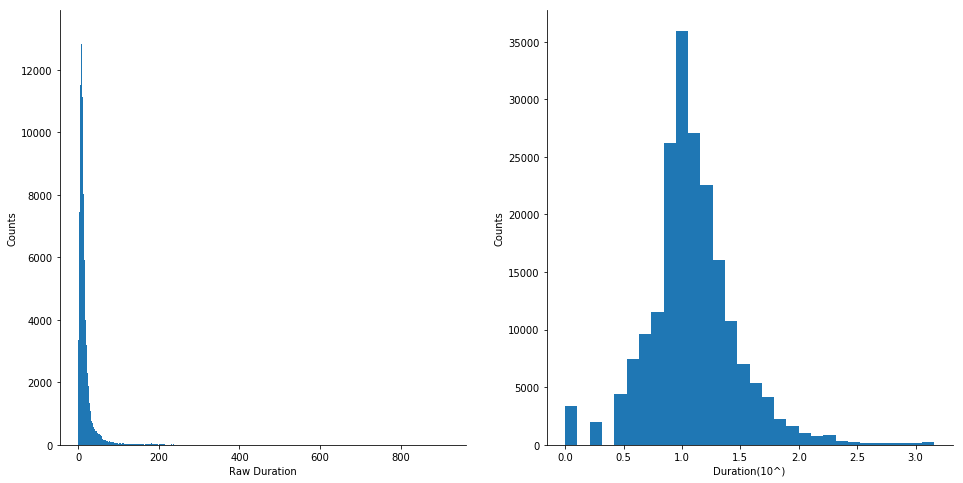

In [18]:
#Trim Trip Duration
# Check trip duration distribution. We can see that the log data is like normal distribution

# Distribution with raw data
plt.figure(figsize=(16, 8))
ax1 = plt.subplot(121)
labels, values = zip(*Counter(df.duration).items())
indexes = np.arange(len(labels))
ax1.bar(indexes,values, 1)
plt.xlabel('Raw Duration')
plt.ylabel('Counts')
ax1.spines['right'].set_color('none')
ax1.spines['top'].set_color('none')

## Distribution with log data 
interval_log = np.log10(np.array(df.duration))
ax2 = plt.subplot(122)
ax2.hist(interval_log, bins=30)
plt.xlabel('Duration(10^)')
plt.ylabel('Counts')
ax2.spines['right'].set_color('none')
ax2.spines['top'].set_color('none')

In [19]:
# Based on the plots, we use logged data to trim trip duration in order to remove some outliers.
duration_mean = np.mean(interval_log)
duration_std = np.std(interval_log)

# Set up upbound and bottom bound. t1 is about 4 hours and t2 is about 2 mins.
t1 = np.mean(interval_log) + 2*np.std(interval_log)
t2 = np.mean(interval_log) - 2*np.std(interval_log)

# Trim raw trips data by t1 and t2
trip = df[(df.duration >= 120) & (df.duration <= 4*3600) ]

Discover Lifecycle Interval
---
Kmeans
--

In [20]:
# Since there is no indicator for a bike's lifecycle, we start from using KMeans to group trips of each bike to try to 
# find lifecycle interval. Using Silhouette coefficient to find the optimal K for a specific bike.
#Discover Lifecycle Interval KM
def timedifference(row):
    """Calculate time difference between each trip of a specific bike.
    """
    startdifference = ((row['start_time']-initialstart)/np.timedelta64(1, 'h'))
    enddifference   = ((row['end_time']-initialend)/np.timedelta64(1, 'h'))
    return pd.Series((startdifference, enddifference))

def sil_cal_elbow(X, start, end):
    """Calculate silhouette coeff with different k.
    """
    result_list = []
    for n in range(start, end+1):
        kmeans = KMeans(n_clusters=n)
        p = kmeans.fit(X)
        t = metrics.silhouette_score(X, p.labels_)
        result_list.append(t)
    return result_list

def generatetraining(choose_id):
    """Generate subset based on bike id.
    """
    global initialstart
    global initialend
    df['start_time'] = pd.to_datetime(df['start_time'], errors='coerce')
    df['start_time'] = pd.to_datetime(df['start_time'], errors='coerce')
    
    test = df[df.bike_id == choose_id]
    
    test = test.sort_values('start_time')
    test['start_time']=pd.to_datetime(test['start_time'].values)
    test['end_time']=pd.to_datetime(test['end_time'].values)
    initialstart = test.iloc[0].start_time
    initialend   = test.iloc[0].end_time
    training_feature  = test.apply(timedifference, axis=1)
    training_feature.columns = ['start_diff', 'end_diff']
    return training_feature

def siloutteplot(training_feature):
    """Plot siloutte vs K.
    """
    t = sil_cal_elbow(training_feature, 2, 10)
    fig, ax = plt.subplots(figsize = [8,8], facecolor=[0.9,0.9,0.9])
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    x_axis=list(range(2,11))
    y_axis=t
    ax.plot(x_axis, t, 'b*-')
    plt.xlabel('K')
    plt.ylabel('Coefficient (1 is best, -1 is worst)')
    plt.title('Silhouette coefficient')
    plt.show()

    
def clusterplot(K, training_feature):
    """Plot clutered trips with optimal K.
    """
    km = KMeans(K)
    km.fit(training_feature)
    mu = km.cluster_centers_
    labels = km.labels_
    fig, ax = plt.subplots(figsize = [8,8], facecolor=[0.9,0.9,0.9])
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.scatter(training_feature['start_diff'], training_feature['end_diff'], c=labels, alpha=0.4)
    ax.scatter(mu[:,0], mu[:,1], s=300, c=np.unique(labels))
    plt.xlabel('start time')
    plt.ylabel('end time')
    plt.show()

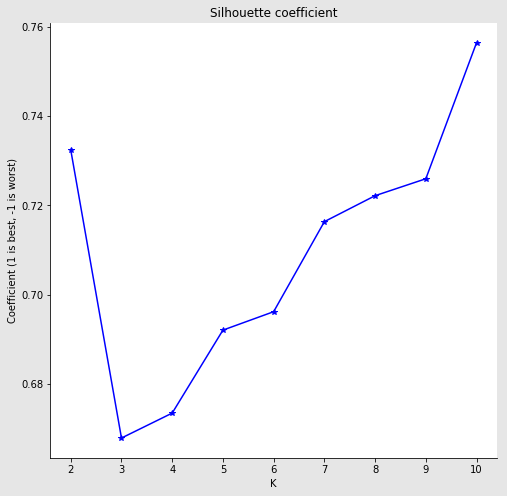

In [21]:
# KMeans with bike_id 2497
#df['bike_id'].value_counts: Series.value_counts of trip_id
#241475855     2497
#241475854    11738
#241475851     3658

training_feature = generatetraining(2497)
siloutteplot(training_feature)

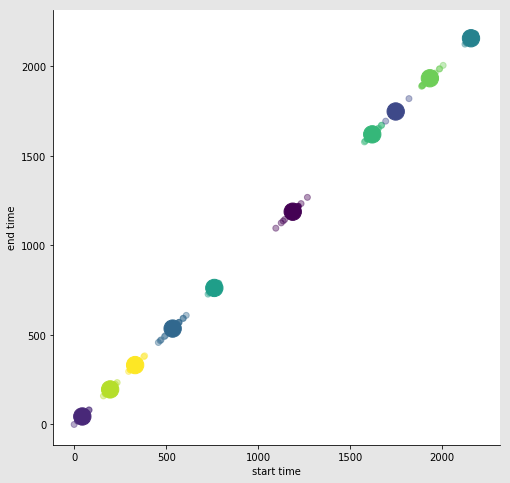

In [22]:
# The optimal K from the above plot is 9. And the clustering for bike id 2497 is pretty good
clusterplot(10, training_feature)

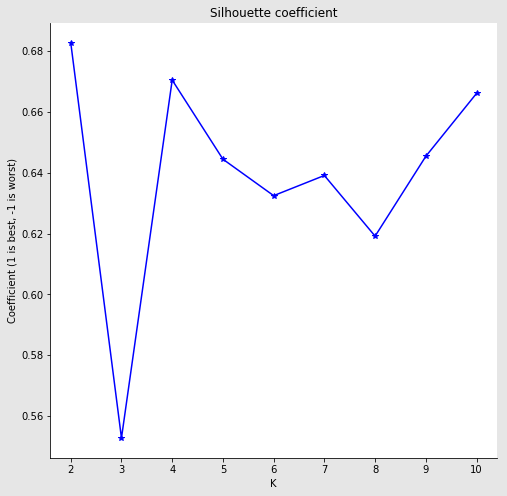

In [23]:
# KMeans with bike_id 3658
training_feature = generatetraining(3658)
siloutteplot(training_feature)

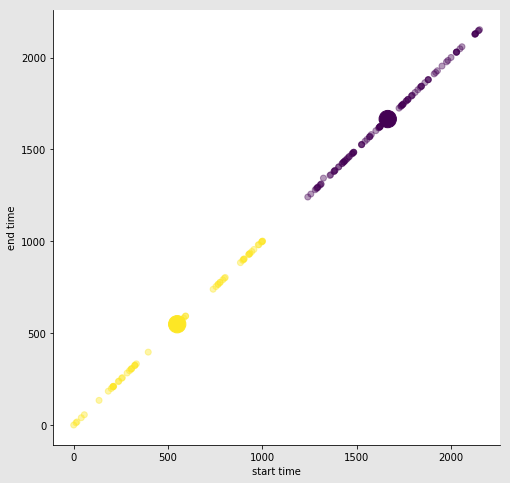

In [24]:
# The optimal K from the above plot is 2. And the clustering for bike id 342 is not that good.
clusterplot(2, training_feature)

From the above two exampels, the method is KMenas fails to find the duration interval for all bikes. With the statistical method to get a reasonal duration interval based on the assumption that duration interval is normal distribution.


In [25]:
#Probability Value
def collectinterval(dataset):
    """Collect all trip intervals.
    """
    interval_list = []
    bikeid = set(dataset.bike_id.unique())
    for bike_id in bikeid:
        temp = dataset[dataset['bike_id'] == bike_id] 
        temp.loc[:,'start_time'] =pd.to_datetime(temp['start_time'].values)
        temp.loc[:,'end_time'] =pd.to_datetime(temp['end_time'].values)
        temp = temp.sort_values(by=['start_time'])
        for i in range(1, len(temp)):
            t = int((temp.iloc[i].start_time-temp.iloc[i-1].end_time)/np.timedelta64(1, 'm'))
            interval_list.append(t)
    return interval_list
interval_list = collectinterval(trip)

/Users/melike/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


/Users/melike/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
/Users/melike/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log
  


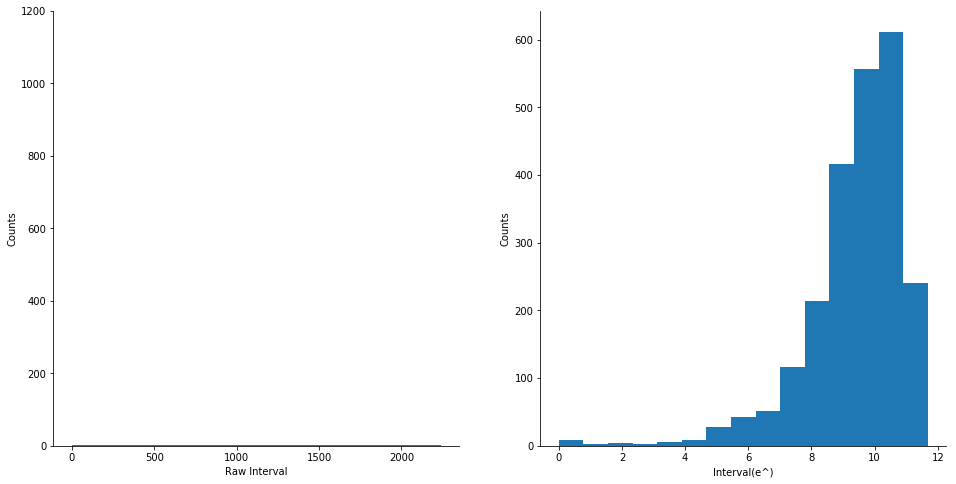

In [27]:
# Distribution with raw data
plt.figure(figsize=(16, 8))
ax3 = plt.subplot(121)
labels, values = zip(*Counter(interval_list).items())
indexes = np.arange(len(labels))
ax3.bar(indexes,values, 1)
plt.xlabel('Raw Interval')
plt.ylabel('Counts')
ax3.set_ylim(0, 1200)
ax3.spines['right'].set_color('none')
ax3.spines['top'].set_color('none')

## Distribution with log data 
interval_lg = np.log(np.array(interval_list))
interval_lg = interval_lg[~np.isnan(interval_lg)]
interval_lg = interval_lg[~np.isinf(interval_lg)]
ax4 = plt.subplot(122)
ax4.hist(interval_lg, bins=15)
plt.xlabel('Interval(e^)')
plt.ylabel('Counts')
ax4.spines['right'].set_color('none')
ax4.spines['top'].set_color('none')

In [30]:
# Calculate the up bound of interval. We get t ~= 7 and t2 ~= 4
t = np.mean(interval_lg) + 2*np.std(interval_lg)  # 95%
t2 = np.mean(interval_lg) + (1.644)*np.std(interval_lg) # 90%
print('t: and t2:', t, t2)

('t: and t2:', 12.492744131340508, 11.944808727885562)


In [ ]:
def tempcovert(temp):
    """Group trips with the calculated interval
    """
    final_id_list = []
    bike_group = []
    counts = 0
    final_id = []
    for i in range(len(temp)):
        old_id = temp.iloc[i].bike_id
        if i == 0:
            bike_group.append(str(old_id) +'_'+str(counts))
        elif i == len(temp)-1:
            bike_group.append(str(old_id) +'_'+str(counts)) 
            final_id = str(old_id) +'_'+str(counts) 
            final_id_list.append(final_id)
        else:
            if (int((temp.iloc[i].start_time-temp.iloc[i-1].end_time)/np.timedelta64(1, 'D')) > 4 and
               temp.iloc[i].start_station != temp.iloc[i-1].end_station):
                counts += 1
            elif int((temp.iloc[i].start_time-temp.iloc[i-1].end_time)/np.timedelta64(1, 'D')) > 7:
                counts += 1
            bike_group.append(str(old_id) +'_'+str(counts))
    result = pd.DataFrame(bike_group, columns = ['bike_group'], index=temp.index)
    temp = pd.concat([temp, result], axis =1)
    return temp, final_id

def generateduration(dataset):
    """Generate new dataset based on lifecycle.
    """
    new_pd = pd.DataFrame()
    finalid_list = []
    id_set = set(dataset.bike_id.unique())
    df['counts'] = df['duration'].value_counts()
    for bikeid in id_set:
        temp = dataset[dataset['bike_id'] == bikeid]
        temp.sort_values(by=['start_time'])
        temp['start_time'] =pd.to_datetime(temp['start_time'].values)
        temp['end_time'] =pd.to_datetime(temp['end_time'].values)
        temp, final_id = tempcovert(temp)
        new_pd = pd.concat([new_pd, temp])
        finalid_list.append(final_id)
    return new_pd, finalid_list

new_pd, finalid_list = generateduration(df)
new_pd_removelast = new_pd[~new_pd['bike_group'].isin(finalid_list)]
new_pd_removelast.to_csv('Dataset/lifecycle_final.csv')

/Users/melike/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/melike/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Data Analysis
====

Current Feature Analysis
===

Duration VS Trips Number
--

In [9]:
#df = pd.read_csv('indego-trips-2018-q2.csv')


In [16]:
# Load raw data
path =r'/Users/melike/machinelearning/INDECO/Indeco_data'
allFiles = glob.glob(path + "/*.csv")
list_ = []

for file_ in allFiles:
    df = pd.read_csv(file_,index_col=None, header=0,parse_dates=['start_time'])
    
    #handle missing column
    df = df.replace('[]', np.nan)
    df = df.replace('...', np.nan)
    #df.replace('',-99999, inplace=True)
    modifiedFlights=df.fillna("...")
    modifiedFlights = df.dropna()
    modifiedFlights.isnull().sum()
    modifiedFlights.to_csv('modifiedFlights.csv',index=False)
    df=df.dropna()
    list_.append(df)
    #df.drop(to_drop, inplace=True, axis=1)
    
    
    
frame = pd.concat(list_)

In [10]:
#df.head()
#df.shape

,trip_id,duration,start_time,end_time,start_station,start_lat,start_lon,end_station,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type
0,4614547,1620,2016-04-01 00:03:00,4/1/2016 0:30,3023,39.95048,-75.17286,3023,39.95048,-75.17286,3509,30,Round Trip,Indego30
1,4614548,780,2016-04-01 00:06:00,4/1/2016 0:19,3009,39.95576,-75.18982,3066,39.94561,-75.17348,2566,30,One Way,Indego30
2,4614549,60,2016-04-01 00:09:00,4/1/2016 0:10,3063,39.94633,-75.16980,3063,39.94633,-75.16980,3281,30,Round Trip,Indego30
3,4614550,360,2016-04-01 00:10:00,4/1/2016 0:16,3063,39.94633,-75.16980,3064,39.93840,-75.17327,3288,30,One Way,Indego30
4,4614551,660,2016-04-01 00:11:00,4/1/2016 0:22,3066,39.94561,-75.17348,3047,39.95071,-75.14921,3404,30,One Way,Indego30


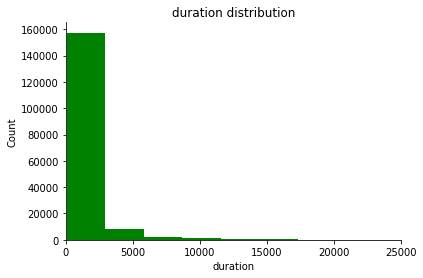

In [142]:
#plt.figure(figsize=(17, 10))
ax6 = plt.subplot(111)
ax6.hist(df['duration'], bins=30, color="green")
plt.xlabel('duration')
plt.ylabel('Count')
plt.title('duration distribution')
ax6.set_xlim(0,25000)
ax6.spines['right'].set_visible(False)
ax6.spines['top'].set_visible(False)

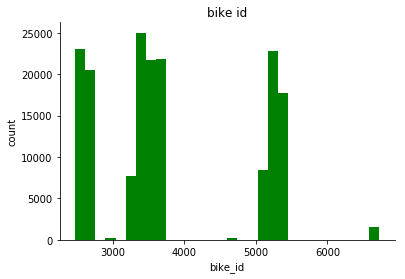

In [143]:
#plt.figure(figsize=(16, 8))
ax2 = plt.subplot(111)
ax2.hist(df['bike_id'], bins=30, color="green")
plt.xlabel('bike_id')
plt.ylabel('count')
plt.title('bike id')
#ax2.set_xlim(0,12000)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

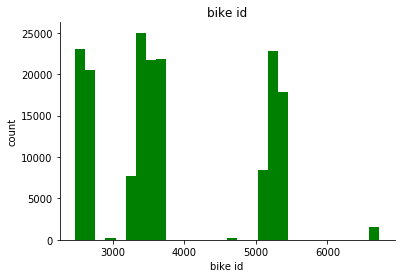

In [144]:
#plt.figure(figsize=(16, 8))
ax2 = plt.subplot(111)
ax2.hist(df['bike_id'], bins=30, color="green")
plt.xlabel('bike id')
plt.ylabel('count')
plt.title('bike id')
#ax2.set_xlim(0,12000)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

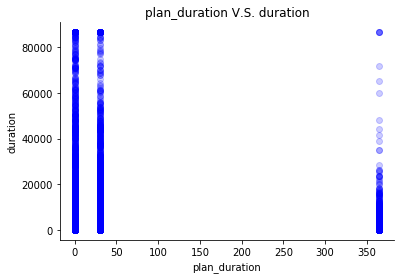

In [145]:
# Second plot: Bike LifeCycle V.S. Trips Number in LifeCycle
#plt.figure(figsize=(16, 8))
ax7 = plt.subplot(111)
ax7.scatter(df['plan_duration'], df['duration'], color='b', alpha=0.2)
plt.xlabel('plan_duration')
plt.ylabel('duration')
plt.title('plan_duration V.S. duration')
#ax7.set_ylim(0, 20000)
ax7.spines['right'].set_visible(False)
ax7.spines['top'].set_visible(False)

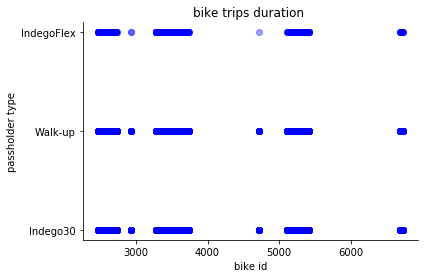

In [146]:

#plt.figure(figsize=(16, 8))
ax77 = plt.subplot(111)
ax77.scatter(df['bike_id'], df['passholder_type'], color='b', alpha=0.2)
plt.xlabel('bike id')
plt.ylabel('passholder type')
plt.title('bike trips duration ')
#ax77.set_ylim(0, 3000)
#ax77.set_xlim(0,12000)
ax77.spines['right'].set_visible(False)
ax77.spines['top'].set_visible(False)

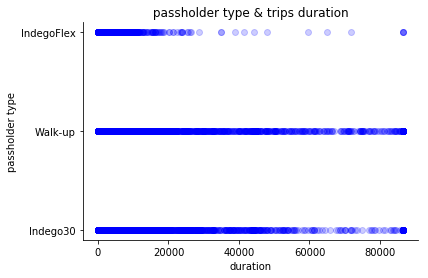

In [147]:
#plt.figure(figsize=(16, 8))
ax87 = plt.subplot(111)
ax87.scatter(df['duration'], df['passholder_type'], color='b', alpha=0.2)
plt.xlabel('duration')
plt.ylabel('passholder type')
plt.title(' passholder type trips duration ')
#ax77.set_ylim(0, 3000)
#ax77.set_xlim(0,12000)
ax87.spines['right'].set_visible(False)
ax87.spines['top'].set_visible(False)

In [1]:
#df.bike_id.head(100)

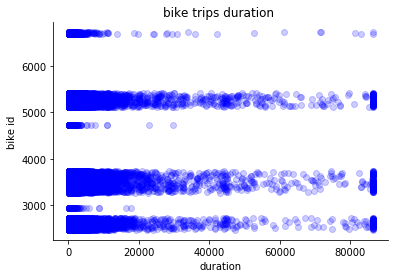

In [109]:
# Second plot: Bike LifeCycle V.S. Trips Number in LifeCycle
#plt.figure(figsize=(16, 8))
ax7 = plt.subplot(111)
ax7.scatter(df['duration'], df['bike_id'], color='b', alpha=0.2)
plt.xlabel('duration')
plt.ylabel('bike id')
plt.title('bike trips duration ')
#ax7.set_xlim(0,12000)
ax7.spines['right'].set_visible(False)
ax7.spines['top'].set_visible(False)

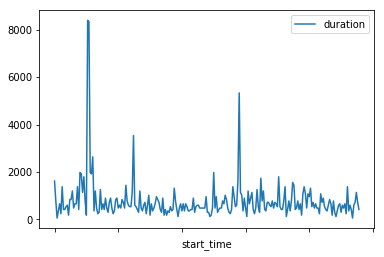

In [148]:
df[:24*10].plot(x='start_time', y='duration')

In [6]:
df[:24*10].plot(x='bike_id', y='duration')

NameError: name 'df' is not defined

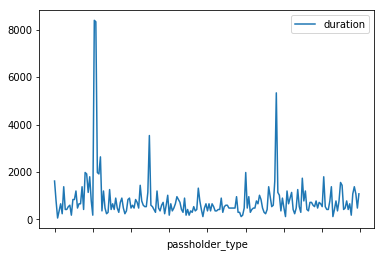

In [108]:
df[:20*10].plot(x='passholder_type', y='duration')

In [151]:
df.sample()

,trip_id,duration,start_time,end_time,start_station,start_lat,start_lon,end_station,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type,year,month,hour,counts
98061,4735895,600,2016-05-31 21:02:00,5/31/2016 21:12,3045,39.94792,-75.16237,3034,39.93315,-75.16248,2686,30,One Way,Indego30,2016,5,21,NaN


In [50]:
df.start_lon.head()

1   -75.174072
2   -75.156952
3   -75.166908
4   -75.194794
5   -75.136414
Name: start_lon, dtype: float64

In [152]:
# Heat Map, Check folder 'Html/heatmap.html'
heatMapData = pd.DataFrame()
d = df[['duration', 'start_lat', 'start_lon']].groupby(['start_lat', 'start_lon']).sum()
lats = []
longs = []
for e in d.index.values.tolist():
    lats.append(e[0])
    longs.append(e[1])
heatMapData['start_lat'] = lats
heatMapData['start_lon'] = longs
heatMapData['duration'] = d.duration.values

In [153]:
data = []
for index, row in heatMapData.iterrows():
    temp = {}
    temp['start_lat'] = row['start_lon']
    temp['start_lon'] = row['start_lon']
    temp['count'] = row['duration']
    data.append(temp)

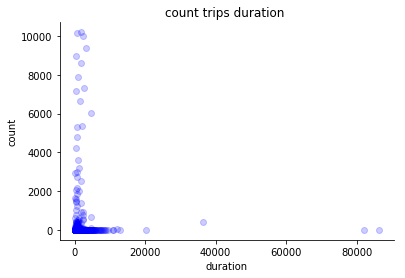

In [154]:
# Second plot: Bike LifeCycle V.S. Trips Number in LifeCycle
#plt.figure(figsize=(16, 8))
ax72 = plt.subplot(111)
ax72.scatter(df['duration'], df['counts'], color='b', alpha=0.2)
plt.xlabel('duration')
plt.ylabel('count')
plt.title('count trips duration ')
#ax72.set_xlim(0,1000)
ax72.spines['right'].set_visible(False)
ax72.spines['top'].set_visible(False)



Trip_summary
==

In [1]:
import csv
from datetime import datetime
import numpy as np
import pandas as pd
from babs_datacheck import question_3
from babs_visualizations import usage_stats, usage_plot
from IPython.display import display
%matplotlib inline

In [47]:
sample_data = pd.read_csv('indego_gbfs_trips_Q2_2017.csv')
sample_data.to_csv('indego_gbfs_trips_Q2_2017.csv', date_format='%m/%d/%Y')

display(sample_data.head(5))

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,trip_id,duration,start_time,end_time,start_station,start_lat,start_lon,end_station,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type
0,0,0,0,0,106996584,8,2017-04-01 00:04:00,2017-04-01 00:12:00,3060,39.959229,-75.170357,3045,39.947922,-75.162369,2554,30,One Way,Indego30
1,1,1,1,1,106996580,7,2017-04-01 00:06:00,2017-04-01 00:13:00,3063,39.946331,-75.169800,3023,39.950481,-75.172859,2510,30,One Way,Indego30
2,2,2,2,2,106996581,3,2017-04-01 00:06:00,2017-04-01 00:09:00,3069,39.937038,-75.150383,3028,39.940609,-75.149582,3578,30,One Way,Indego30
3,3,3,3,3,106996582,3,2017-04-01 00:06:00,2017-04-01 00:09:00,3069,39.937038,-75.150383,3028,39.940609,-75.149582,3307,30,One Way,Indego30
4,4,4,4,4,106996579,10,2017-04-01 00:08:00,2017-04-01 00:18:00,3045,39.947922,-75.162369,3068,39.935490,-75.167107,2606,30,One Way,Indego30


In [49]:



station_info = pd.read_csv('Station_Table.csv')
display(station_info.head())
def create_station_mapping(station_data):
    """
    Create a mapping from station IDs to cities, returning the
    result as a dictionary.
    """
    station_map = {}
    for data_file in station_data:
        with open(data_file, 'r') as f_in:
            # set up csv reader object - note that we are using DictReader, which
            # takes the first row of the file as a header row for each row's
            # dictionary keys
            weather_reader = csv.DictReader(f_in)

            for row in weather_reader:
                station_map[row['Station ID']] = row['Station Name']
    return station_map

,Station ID,Station Name,Go live date,Status
0,3000,Virtual Station,4/23/2015,Active
1,3004,Municipal Services Building Plaza,4/23/2015,Active
2,3005,Welcome Park NPS,4/23/2015,Active
3,3006,40th & Spruce,4/23/2015,Active
4,3007,11th & Pine Kahn Park,4/23/2015,Active


In [50]:
def summarise_data(trip_in, station_data, trip_out):
    """
    This function takes trip and station information and outputs a new
    data file with a condensed summary of major trip information. The
    trip_in and station_data arguments will be lists of data files for
    the trip and station information, respectively, while trip_out
    specifies the location to which the summarized data will be written.
    """
    # generate dictionary of station - city mapping
    station_map = create_station_mapping(station_data)

    with open(trip_out, 'w') as f_out:
        # set up csv writer object        
        out_colnames = ['duration', 'start_date', 'start_year',
                        'start_month', 'start_hour','start_sn', 'weekday',
                        'start_city', 'end_city', 'subscription_type']        
        trip_writer = csv.DictWriter(f_out, fieldnames = out_colnames)
        trip_writer.writeheader()

        for data_file in trip_in:
            with open(data_file, 'r') as f_in:
                # set up csv reader object
                trip_reader = csv.DictReader(f_in)

                # collect data from and process each row
                for row in trip_reader:
                    new_point = {}

                    # convert duration units from seconds to minutes
                    ### Question 3a: Add a mathematical operation below   ###
                    ### to convert durations from seconds to minutes.     ###
                    new_point['duration'] = float(row['duration'])/60

                    # reformat datestrings into multiple columns
                    ### Question 3b: Fill in the blanks below to generate ###
                    ### the expected time values.                         ###
                    
                    
                    #trip_date = datetime.strptime(row['start_time'], '%m/%d/%Y %H:%M')
                    trip_date = datetime.strptime(row['start_time'], '%Y-%m-%d %H:%M:%S')
                        
                          
                    #%m/%d/%Y 2016, 4/23/15 2018-01-01 00:24:00:%Y-%m-%d %H:%M:%S
                    
                    new_point['start_date']  = trip_date.strftime('%Y-%m-%d')
                    new_point['start_year']  = trip_date.strftime('%Y')
                    new_point['start_month'] = trip_date.strftime('%m')
                    new_point['start_hour']  = trip_date.strftime('%H')
                    new_point['start_sn']  =  trip_date.strftime('%S')
                    new_point['weekday']     = trip_date.strftime('%A')

                    # remap start and end terminal with start and end city
                    new_point['start_city'] = station_map[row['start_station']]
                    new_point['end_city'] = station_map[row['end_station']]
                    # two different column names for subscribers depending on file
                    if 'Subscription Type' in row:
                        new_point['subscription_type'] = row['passholder_type']
                    else:
                        new_point['subscription_type'] = row['passholder_type']

                    # write the processed information to the output file.
                    trip_writer.writerow(new_point)

In [51]:
station_data = ['Station_Table.csv',
                'Station_Table.csv',
                'Station_Table.csv' ]
trip_in = [#'indego_gbfs_trips_Q1_2017.csv',
            'indego-trips-2017-q3.csv',
            'indego_gbfs_trips_Q2_2017.csv'
           
           #'indego-trips-2018-q3.csv'
          ]
trip_out = 'trips_2017_summary.csv'

# This function will take in the station data and trip data and
# write out a new data file to the name listed above in trip_out.
summarise_data(trip_in, station_data, trip_out)

In [54]:
trip_data = pd.read_csv('trips_2017_summary.csv')

usage_stats(trip_data)

There are 497226 data points in the dataset.
The average duration of trips is 0.37 minutes.
The median trip duration is 0.20 minutes.
25% of trips are shorter than 0.13 minutes.
25% of trips are longer than 0.33 minutes.


babs_visualizations.py:68: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  duration_qtiles = data['duration'].quantile([.25, .5, .75]).as_matrix()


array([0.13333333, 0.2       , 0.33333333])

In [55]:
usage_stats(trip_data,)

There are 497226 data points in the dataset.
The average duration of trips is 0.37 minutes.
The median trip duration is 0.20 minutes.
25% of trips are shorter than 0.13 minutes.
25% of trips are longer than 0.33 minutes.


array([0.13333333, 0.2       , 0.33333333])

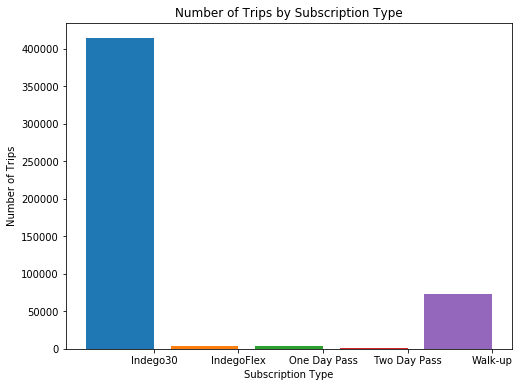

In [56]:
usage_plot(trip_data, 'subscription_type')

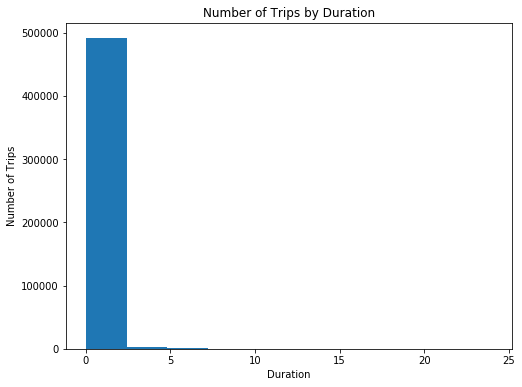

In [57]:
usage_plot(trip_data, 'duration')

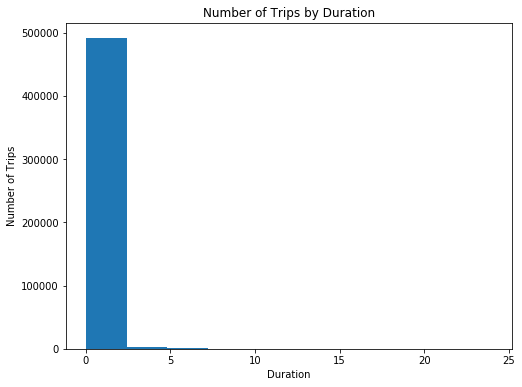

In [58]:
usage_plot(trip_data, 'duration', ['duration < 60'])

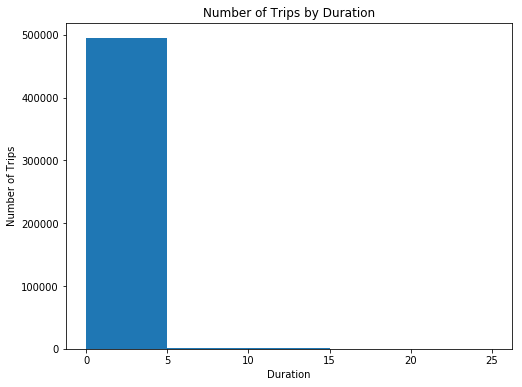

In [59]:
usage_plot(trip_data, 'duration', ['duration < 60'], boundary = 0, bin_width = 5)

In [60]:
usage_stats(trip_data,)

There are 497226 data points in the dataset.
The average duration of trips is 0.37 minutes.
The median trip duration is 0.20 minutes.
25% of trips are shorter than 0.13 minutes.
25% of trips are longer than 0.33 minutes.


array([0.13333333, 0.2       , 0.33333333])

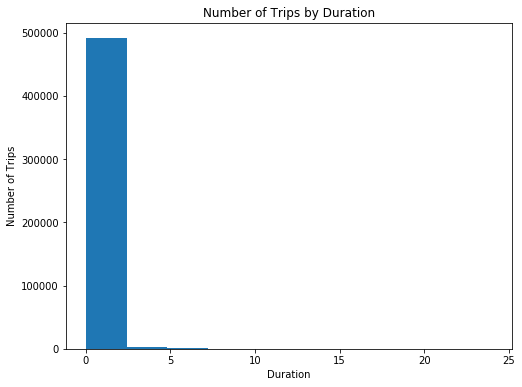

In [63]:
usage_plot(trip_data, 'duration')

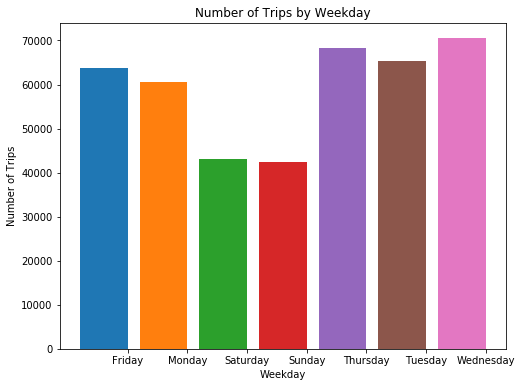

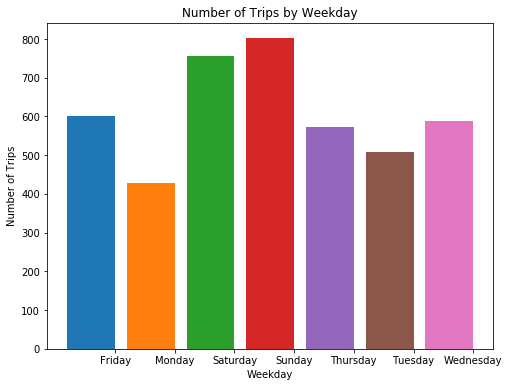

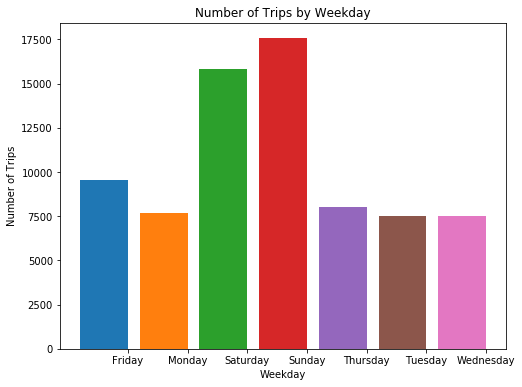

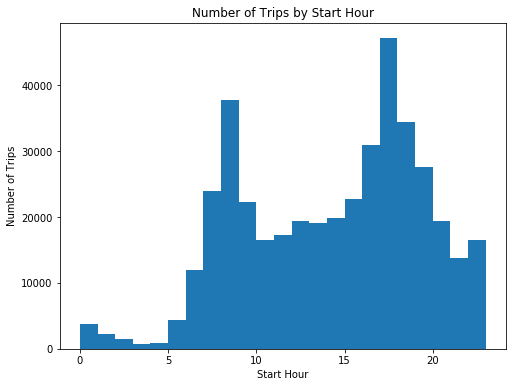

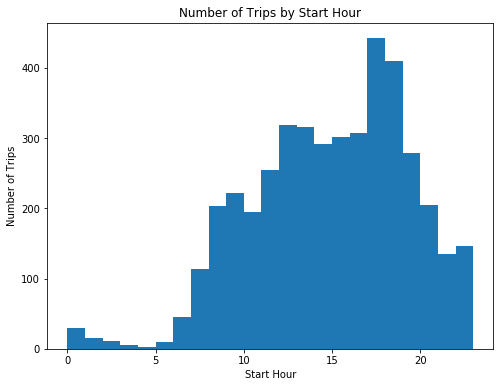

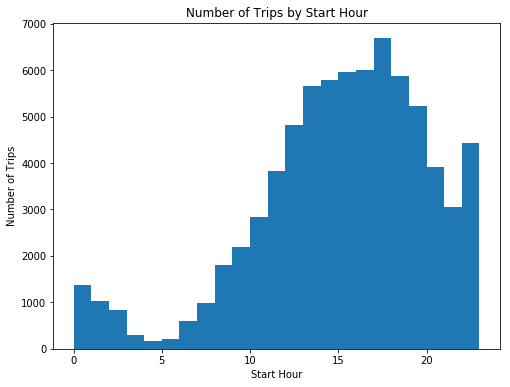

In [64]:
usage_plot(trip_data,'weekday', ["subscription_type == 'Indego30'"])
usage_plot(trip_data,'weekday', ["subscription_type == 'IndegoFlex'"])
usage_plot(trip_data,'weekday', ["subscription_type == 'Walk-up'"])
usage_plot(trip_data,'start_hour', ["subscription_type == 'Indego30'"],bin_width=1)
usage_plot(trip_data,'start_hour', ["subscription_type == 'IndegoFlex'"],bin_width=1)
usage_plot(trip_data,'start_hour', ["subscription_type == 'Walk-up'"],bin_width=1)
#usage_plot(trip_data,'start_hour', ["subscription_type == 'Customer'"],bin_width=1)

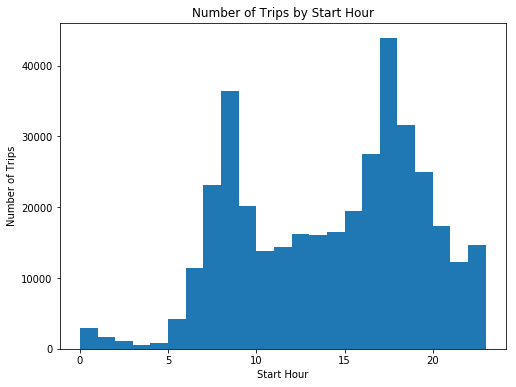

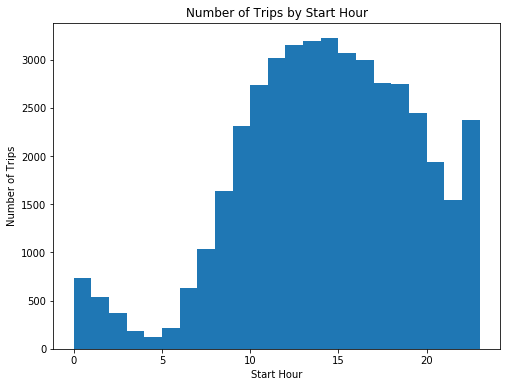

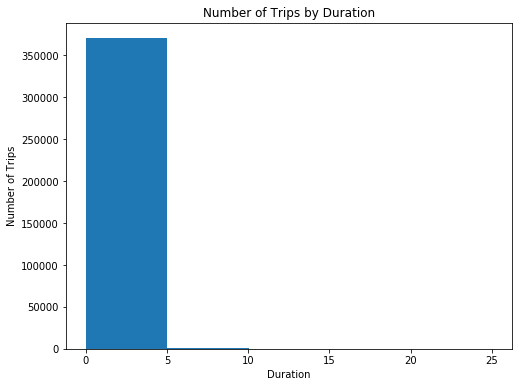

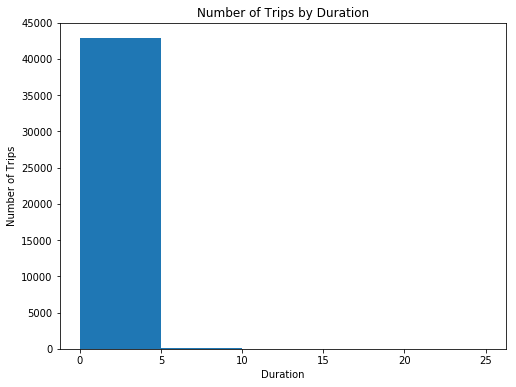

In [65]:
usage_plot(trip_data,'start_hour', [("weekday != 'Saturday'") and ("weekday != 'Sunday'"), "subscription_type == 'Indego30'"],bin_width=1)
usage_plot(trip_data,'start_hour', [("weekday == 'Saturday'") or ("weekday == 'Sunday'"), "subscription_type == 'Indego30'"],bin_width=1)
usage_plot(trip_data,'duration', [("weekday != 'Saturday'") and ("weekday != 'Sunday'"), "duration < 60", "subscription_type == 'Indego30'"],bin_width=5)
usage_plot(trip_data,'duration', [("weekday == 'Saturday'") or ("weekday == 'Sunday'"), "duration < 60", "subscription_type == 'Indego30'"],bin_width=5)

Modeling
===

In [46]:
# Load raw data
path =r'/Users/melike/machinelearning/INDECO/Indeco_data'
allFiles = glob.glob(path + "/*.csv")
list_ = []

for file_ in allFiles:
    df = pd.read_csv(file_,index_col=None, header=0)
    
    #handle missing column
    df = df.replace('[]', np.nan)
    df = df.replace('...', np.nan)
    #df.replace('',-99999, inplace=True)
    modifiedFlights=df.fillna("...")
    modifiedFlights = df.dropna()
    modifiedFlights.isnull().sum()
    modifiedFlights.to_csv('modifiedFlights.csv',index=False)
    df=df.dropna()
    list_.append(df)
    #df.drop(to_drop, inplace=True, axis=1)
    
frame = pd.concat(list_)

In [47]:
df.shape

(174522, 14)

In [48]:
df.head(2)

,trip_id,duration,start_time,end_time,start_station,start_lat,start_lon,end_station,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type
0,55223952,480,10/1/2016 0:06,10/1/2016 0:14,3050,39.953388,-75.154259,3030,39.939350,-75.157158,5255,30,One Way,Indego30
1,55223954,180,10/1/2016 0:06,10/1/2016 0:09,3066,39.945610,-75.173477,3032,39.945271,-75.179710,3595,30,One Way,Indego30


In [49]:
#df.bike_id.head()
df.dtypes

trip_id                  int64
duration                 int64
start_time              object
end_time                object
start_station            int64
start_lat              float64
start_lon              float64
end_station              int64
end_lat                float64
end_lon                float64
bike_id                  int64
plan_duration            int64
trip_route_category     object
passholder_type         object
dtype: object

In [50]:
df.start_station= df.start_station.astype(float).fillna(0.0)
df.duration= df.duration.astype(float).fillna(0.0)
df.bike_id= df.bike_id.astype(float).fillna(0.0)
df.plan_duration= df.plan_duration.astype(float).fillna(0.0)
df.end_station= df.end_station.astype(float).fillna(0.0)
# df.drop(['passholder_type'], 1, inplace=True) 
# df.drop(['trip_route_category'], 1, inplace=True)
#df['start_time'] = pd.to_datetime(df['start_time'], errors='coerce')
#df['end_time'] = pd.to_datetime(df['start_time'], errors='coerce')

In [51]:
df['start_time'] = pd.to_datetime(df['start_time'], errors='coerce')
df['end_time'] = pd.to_datetime(df['start_time'], errors='coerce')
to_drop = ['passholder_type',
           'trip_route_category',
            'start_time',
            'end_time',
           'trip_id'
           
            ]
df.drop(to_drop, inplace=True, axis=1)

Linear Regression
==

Fitting Model
--

In [52]:
df.reset_index(drop=True, inplace=True)
df = df[df['duration']>0]
#df = df[df['duration']<= 600]
 #statisticalnormalization Z score
def standardize(raw_data):
    return ((raw_data - np.mean(raw_data, axis = 0)) / np.std(raw_data, axis = 0))

 #normalized = (x-min(x))/(max(x)-min(x))
    #raw =([train, np.min(raw_data, axis = 0)], [train, np.max(raw_data, axis = 0)])
    #return ((raw_data - np.min(raw_data, axis = 0)) / (np.max(raw_data, axis = 0) - np.max(raw_data, axis = 0)))




In [53]:
rmse_ratio_train = []
rmse_ratio_test = []
error_ratio_train = []
error_ratio_test = []
row_name = []
# shuffle and generate index for training/test
np.random.seed(seed=13579)
#print(int(len(df) * .8))
#train_idx = np.random.choice(range(len(df)), int(len(df) * .8), replace=False)
train_idx = np.random.choice(range(len(df)), 159880, replace=False)
test_idx = list(set(range(len(df))) - set(list(train_idx)))
#print('test_idx', test_idx)

# generate training/test
bdata_train = df.loc[train_idx]
bdata_test = df.loc[test_idx]
bdata_train.reset_index(drop=True, inplace=True)
bdata_test.reset_index(drop=True, inplace=True)

# remove unnecessary columns
train_feature = bdata_train.drop(['duration'], axis=1)
test_feature = bdata_test.drop(['duration'], axis=1)
train_target = bdata_train['duration']
test_target = bdata_test['duration']

train_feature = standardize(train_feature)
test_feature = standardize(test_feature)
print('test_featurestndard', test_feature)


('test_featurestndard',        start_station  start_lat  start_lon  end_station   end_lat   end_lon  \
0          -0.483001  -1.688060   0.436322     0.088603 -0.455849  0.715619   
1           0.241587   1.195724  -0.010726     0.691449 -1.564627  1.409945   
2          -0.815104  -0.218524  -0.179690     0.390026 -0.055272 -0.636342   
3           0.211396   0.963464  -0.603228     1.776573  0.047241  0.200723   
4           0.211396   0.963464  -0.603228    -1.267801 -0.640889  0.536668   
5           0.060440  -0.486653   0.764692     0.631165  0.690058  1.745409   
6           0.845411   0.041549  -0.124002     0.631165  0.690058  1.745409   
7           0.120822   0.800823  -0.259422     0.299599  0.864847  0.427434   
8          -0.905678  -0.354963  -1.188843    -1.177374 -0.473939  0.160362   
9           0.241587   1.195724  -0.010726    -1.328086 -0.454901  1.493014   
10         -1.388737   0.061307   0.361577    -1.237659  2.426837  1.100647   
11          1.962485   1.659

In [56]:
def compute_rmse(predictions, yvalues):
    # compute_rmse
    assert len(predictions) == len(yvalues)
    rmse = np.sqrt(np.sum(np.power(np.subtract(predictions, yvalues),2))/len(yvalues))
    return rmse

def getaccu_lasso(train_feature, train_target):
    # get the validation score for the lasso model
    kf = KFold(10,random_state=2017)
    clf_dict = {}
    valid_accu = []
    for train_index, test_index in kf.split(train_feature):
        X_train, y_train = train_feature.loc[train_index], train_target.loc[train_index].values
        X_test, y_test = train_feature.loc[test_index], train_target.loc[test_index].values
        clf = Lasso()
        clf.fit(X_train, y_train)
        valid_rmse = compute_rmse(clf.predict(X_test),y_test) 
        valid_accu.append(valid_rmse)
        clf_dict[valid_rmse] = clf
    return valid_accu, clf_dict

def caculateratio(clf, feature, target):
    # caculate the error precetange of the deviation of the predicted value to the actual valus
    predict_y = clf.predict(feature)
    compare_predict = pd.concat([target, pd.DataFrame(predict_y)], axis=1)
    compare_predict.columns = ['true', 'predict']
    compare_predict['error_precent'] = (compare_predict.predict - compare_predict.true) / compare_predict.true
    compare_predict['abs_precent'] = np.abs(compare_predict['error_precent'])
    
    return compare_predict




Optimization - with trips count
--

In [ ]:
from sklearn.model_selection import GridSearchCV

#model = Lasso()
#alpha_list = list(range(1,50))
#parameters = {'alpha':alpha_list,'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
#grid = GridSearchCV(model, parameters, cv=10)
#grid.fit(train_feature, train_target)
#print("r2 / variance : ", grid.best_score_)
#print(compute_rmse(grid.predict(test_feature),test_target))
#grid.best_params_


So the best parameters using all features are: {'alpha': 1, 'copy_X': True, 'fit_intercept': True, 'normalize': False}

In [57]:
##### {'alpha': 1, 'copy_X': True, 'fit_intercept': True, 'normalize': False}
model = Lasso(alpha=1, copy_X=True, fit_intercept=True, normalize=False)
model.fit(train_feature, train_target)

Lasso(alpha=1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [58]:
model.coef_[1:]

array([ 55.64429225,   7.14065758,  54.36511604,  76.08809944,
       -16.99802112,   0.        , -45.9842094 ])

In [59]:
rmse_opti_oaf_train = compute_rmse(model.predict(train_feature),train_target)/np.mean(train_target)
rmse_opti_oaf_test =compute_rmse(model.predict(test_feature),test_target)/np.mean(test_target)
row_name.append('original_allfeatures')
rmse_ratio_train.append(rmse_opti_oaf_train)
rmse_ratio_test.append(rmse_opti_oaf_test)

In [60]:
compare_predict_train_opti_oaf = caculateratio(model, train_feature, train_target)
error_ratio_train.append(compare_predict_train_opti_oaf.abs_precent.median())
compare_predict_test_opti_oaf = caculateratio(model, test_feature, test_target)
error_ratio_test.append(compare_predict_test_opti_oaf.abs_precent.median())

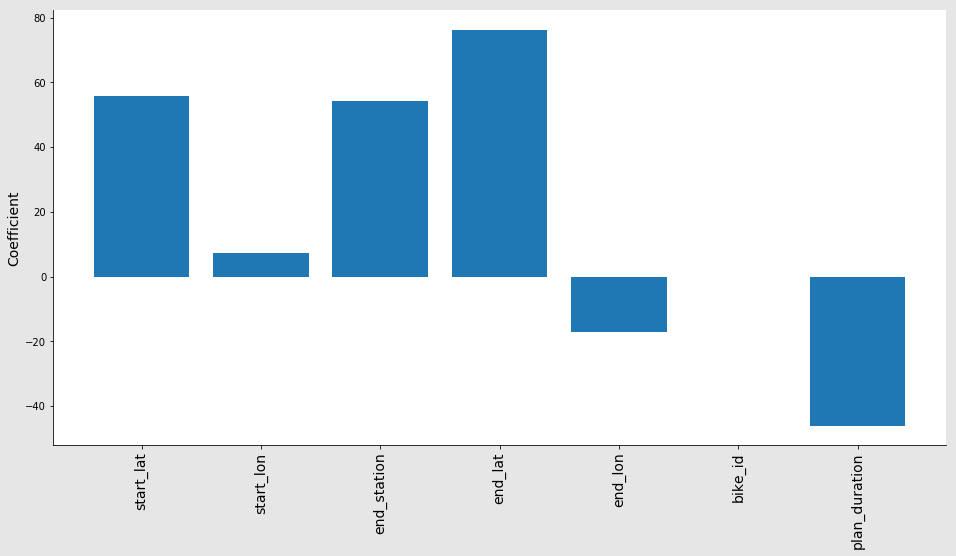

In [61]:
fig, ax = plt.subplots(figsize = [16,8], facecolor = [0.9,0.9,0.9])
x_pos = np.arange(len(train_feature.columns)-1)
 
plt.bar(x_pos, model.coef_[1:])
plt.xticks(x_pos, train_feature.columns[1:], rotation='vertical', fontsize='14')
plt.ylabel('Coefficient',fontsize='14')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.show()

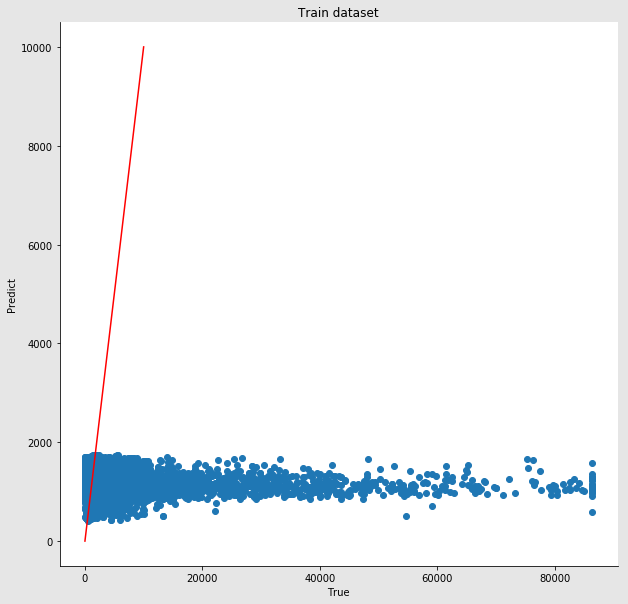

In [63]:
fig, ax = plt.subplots(figsize = [10,10], facecolor = [0.9,0.9,0.9])

x_axis = compare_predict_train_opti_oaf.true
y_axis = compare_predict_train_opti_oaf.predict
x_axis2 = range(10000)
y_axis2 = range(10000)

plt.scatter(x_axis, y_axis)
plt.plot(x_axis2, y_axis2, 'r')
plt.xlabel('True')
plt.ylabel('Predict')
plt.title('Train dataset')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.show()

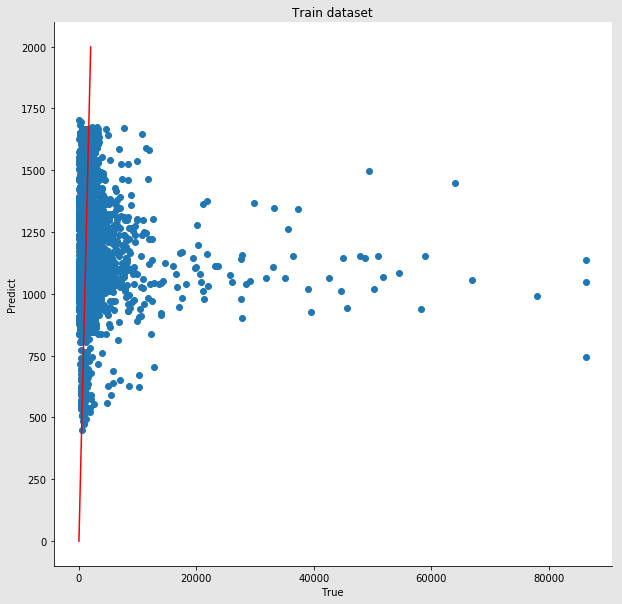

In [65]:
fig, ax = plt.subplots(figsize = [10,10], facecolor = [0.9,0.9,0.9])

x_axis = compare_predict_test_opti_oaf.true
y_axis = compare_predict_test_opti_oaf.predict
x_axis2 = range(2000)
y_axis2 = range(2000)

plt.scatter(x_axis, y_axis)
plt.plot(x_axis2, y_axis2, 'r')
#plt.xticks(x_pos, train_feature.columns, rotation='vertical')
#plt.hist(interval_log, bins=30, alpha=0.75)
plt.xlabel('True')
plt.ylabel('Predict')
plt.title('Train dataset')
#plt.axis([0, 10000, 0, 1000000])
#ax.set_xlim([0, 20])
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.show()

Optimization - without trips count
--

In [66]:
train_feature_notrip = train_feature.drop(['end_lat'], axis=1)
test_feature_notrip = test_feature.drop(['end_lat'], axis=1)

In [ ]:
from sklearn.model_selection import GridSearchCV

#model = Lasso()
#alpha_list = list(range(1,50))
#parameters = {'alpha':alpha_list,'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
#grid = GridSearchCV(model, parameters, cv=10)
#grid.fit(train_feature, train_target)
#print("r2 / variance : ", grid.best_score_)
#print(compute_rmse(grid.predict(test_feature),test_target))
#grid.best_params_



So the best parameters using all features are: {'alpha': 1, 'copy_X': True, 'fit_intercept': True, 'normalize': False}

In [67]:
model = Lasso(alpha=1, copy_X=True, fit_intercept=True, normalize=False)
model.fit(train_feature_notrip, train_target)

Lasso(alpha=1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [68]:
rmse_opti_notc_train = compute_rmse(model.predict(train_feature_notrip),train_target)/np.mean(train_target)
rmse_opti_notc_test =compute_rmse(model.predict(test_feature_notrip),test_target)/np.mean(test_target)
row_name.append('original_withouttripcount')
rmse_ratio_train.append(rmse_opti_notc_train)
rmse_ratio_test.append(rmse_opti_notc_test)

In [69]:
compare_predict_train_opti_notc = caculateratio(model, train_feature_notrip, train_target)
error_ratio_train.append(compare_predict_train_opti_notc.abs_precent.median())
compare_predict_test_opti_notc = caculateratio(model, test_feature_notrip, test_target)
error_ratio_test.append(compare_predict_test_opti_notc.abs_precent.median())

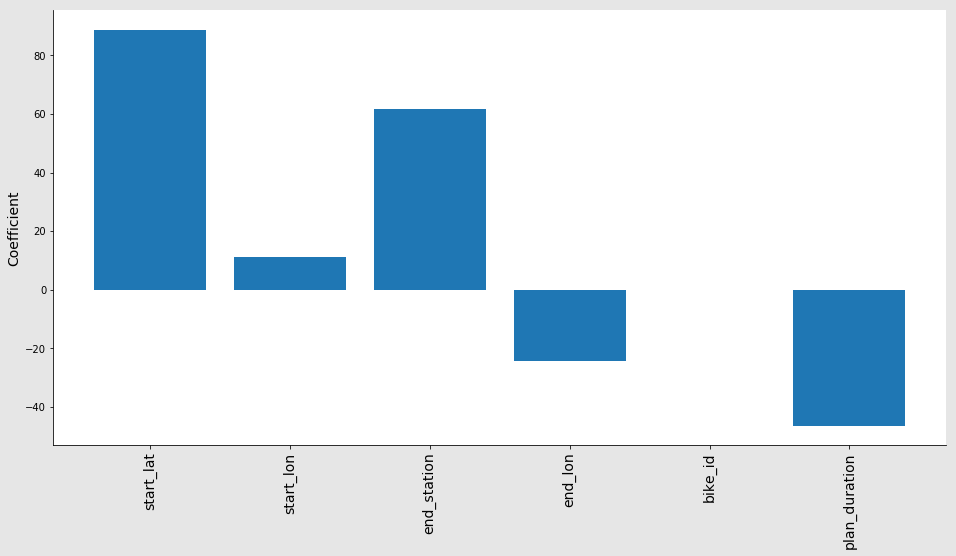

In [70]:
fig, ax = plt.subplots(figsize = [16,8], facecolor = [0.9,0.9,0.9])
x_pos = np.arange(len(train_feature_notrip.columns)-1)
 
plt.bar(x_pos, model.coef_[1:])
plt.xticks(x_pos, train_feature_notrip.columns[1:], rotation='vertical')
plt.xticks(x_pos, train_feature_notrip.columns[1:], rotation='vertical', fontsize='14')
plt.ylabel('Coefficient',fontsize='14')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.show()

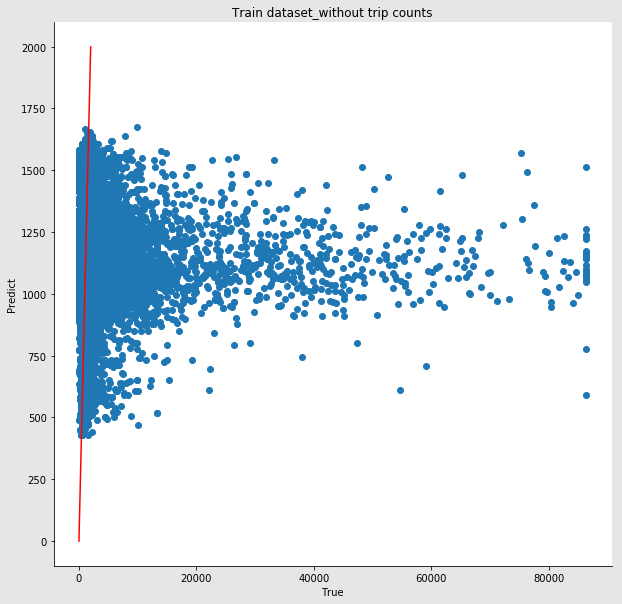

In [71]:
fig, ax = plt.subplots(figsize = [10,10], facecolor = [0.9,0.9,0.9])

x_axis = compare_predict_train_opti_notc.true
y_axis = compare_predict_train_opti_notc.predict
x_axis2 = range(2000)
y_axis2 = range(2000)

plt.scatter(x_axis, y_axis)
plt.plot(x_axis2, y_axis2, 'r')
plt.xlabel('True')
plt.ylabel('Predict')
plt.title('Train dataset_without trip counts')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.show()

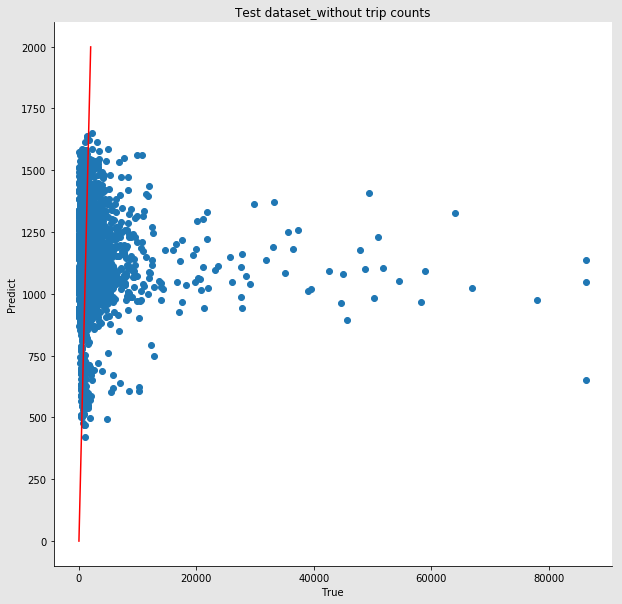

In [72]:
fig, ax = plt.subplots(figsize = [10,10], facecolor = [0.9,0.9,0.9])

x_axis = compare_predict_test_opti_notc.true
y_axis = compare_predict_test_opti_notc.predict
x_axis2 = range(2000)
y_axis2 = range(2000)

plt.scatter(x_axis, y_axis)
plt.plot(x_axis2, y_axis2, 'r')
plt.xlabel('True')
plt.ylabel('Predict')
plt.title('Test dataset_without trip counts')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.show()

Error Analysis
--

In [75]:
def getimportantfeature(model, feature, number=5):
    # calculate the most X important features
    important_list = []
    number_list = list(range(-number, 0))
    temp = np.argpartition(np.abs(model.coef_), number_list)
    for i in number_list[::-1]:
        important_list.append(feature.columns.tolist()[temp[i]])
    return important_list

def getsimilarrow(dataset, index, feature_list, round_number=1):
    # get the similar samples
    sample = dataset.iloc[index]
    subset = dataset[dataset[feature_list[0]].round(round_number) == sample[feature_list[0]].round(round_number)]
    for feature in feature_list:
        subset = subset[subset[feature].round(round_number) == sample[feature].round(round_number)]
    return subset

def comparesimilar(subset_index, index, target):
    # get the value of the target and the mean value of the similar samples
    subset_value = pd.DataFrame(target).loc[subset_index]
    compare_value = subset_value.loc[index]
    subset_value = subset_value[subset_value.index !=index]
    print('outlier value:', compare_value)
    print('mean of similar observations:', subset_value.duration.mean())
    print('median of similar observations:', subset_value.duration.median())
    return compare_value, subset_value

In [76]:
model = Lasso(alpha=1, copy_X=True, fit_intercept=True, normalize=False)
model.fit(train_feature, train_target)

Lasso(alpha=1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [77]:
important_list = getimportantfeature(model, train_feature, 1)
important_list

['end_lat']

In [78]:
subset = getsimilarrow(train_feature, 1325, important_list, round_number=1)
subset.shape

(677, 8)

In [79]:
compare_value, subset_value = comparesimilar(subset.index, 1325, train_target)

('outlier value:', duration    420.0
Name: 1325, dtype: float64)
('mean of similar observations:', 1377.1597633136096)
('median of similar observations:', 960.0)


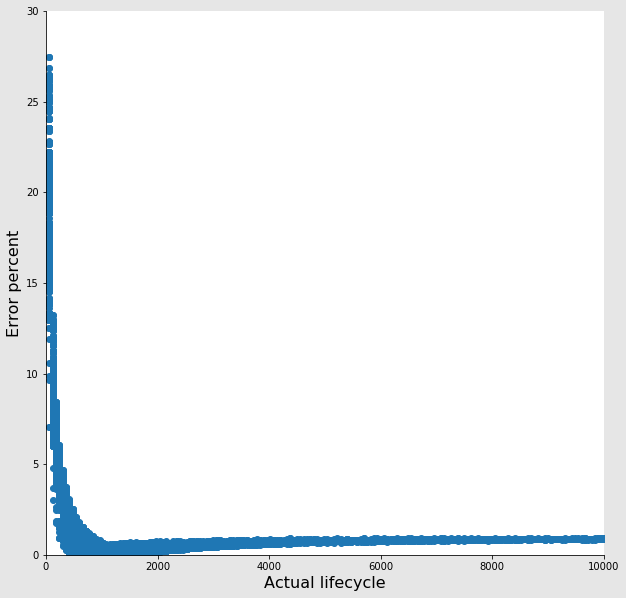

In [81]:
fig, ax = plt.subplots(figsize = [10,10], facecolor = [0.9,0.9,0.9])
x_axis = compare_predict_train_opti_oaf.true
y_axis = compare_predict_train_opti_oaf.abs_precent
plt.xlabel('Actual lifecycle', fontsize = '16')
plt.ylabel('Error percent', fontsize = '16')
plt.scatter(x_axis, y_axis)
plt.axis([0, 10000, 0, 30])
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.show()


In [82]:
# When duration is less than 800 seconds, the error precentage also tends to be huge
temp = compare_predict_train_opti_oaf[compare_predict_train_opti_oaf.true<800]
temp.abs_precent.mean(), temp.abs_precent.median()

(1.9269432074039556, 1.189800401993531)

In [83]:
# When n_clicks is less than 800 seconds, the error precentage also tends to be huge

temp = compare_predict_train_opti_oaf[compare_predict_train_opti_oaf.true<800]
temp = temp.replace(np.inf, 0)
temp = temp.replace(-np.inf, 0)
temp.predict = temp.predict.astype(int)
#print(temp)

temp.abs_precent.mean(), temp.abs_precent.median()
temp.mean(),temp.median()

(true              485.522445
 predict          1087.300496
 error_precent       1.926053
 abs_precent         1.926943
 dtype: float64, true              480.0000
 predict          1061.0000
 error_precent       1.1898
 abs_precent         1.1898
 dtype: float64)

In [84]:
predictions = temp.predict
print(predictions)
#submission = pd.DataFrame({'bike_id':test['bike_id'],'duration':predictions})
#submission.head(100)
#print submission
#train.to_csv('submission.csv')
#= pd.DataFrame({'hotel_id': test.hotel_id, 'n_clicks': predection})
#submission.to_csv('submission_bike.csv', index=False)

0         1287
1         1120
2          960
3         1126
5         1256
8         1136
10        1334
12        1030
14        1079
15        1044
16        1322
18        1197
20        1096
22        1113
25        1100
27        1317
28        1274
30        1105
31        1053
32        1143
33        1071
34        1299
36        1030
37        1161
38         977
39        1413
45        1424
49         925
50         978
58         985
          ... 
159836     982
159838    1033
159839    1071
159842     948
159843    1323
159844    1311
159845     981
159846    1099
159847    1306
159848    1311
159849    1101
159851    1324
159852    1252
159853     926
159854    1046
159856    1124
159858    1030
159862     948
159863    1029
159864     964
159865    1113
159866    1009
159867    1088
159868    1019
159870    1313
159872    1032
159874     959
159875     926
159877    1076
159879    1086
Name: predict, Length: 97685, dtype: int64


Thus we think these duration < 800 are noise and decide to remove them from the original dataset

Trim Dataset
--

In [85]:
trim_cycle = df[df.duration > 800]

In [86]:
# reset index
trim_cycle.reset_index(drop=True, inplace=True)

# shuffle and generate index for training/test
np.random.seed(seed=13579)
#train_idx = np.random.choice(range(len(life_cycle)), int(len(life_cycle) * .8), replace=False)
train_idx = np.random.choice(range(len(trim_cycle)), 2800, replace=False)
test_idx = list(set(range(len(trim_cycle))) - set(list(train_idx)))

# generate training/test
bdata_train = trim_cycle.loc[train_idx]
bdata_test = trim_cycle.loc[test_idx]
bdata_train.reset_index(drop=True, inplace=True)
bdata_test.reset_index(drop=True, inplace=True)

# remove unnecessary columns
train_feature_800 = bdata_train.drop(['duration'], axis=1)
test_feature_800 = bdata_test.drop(['duration'], axis=1)
train_target_800 = bdata_train['duration']
test_target_800 = bdata_test['duration']

With all features
--

In [87]:
# find the best parameters 
#model = Lasso()
#alpha_list = list(range(1,50))
#parameters = {'alpha':alpha_list,'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
#grid = GridSearchCV(model, parameters, cv=10)
#grid.fit(train_feature, train_target)
#print("r2 / variance : ", grid.best_score_)
#print(compute_rmse(grid.predict(test_feature),test_target))
#grid.best_params_



In [88]:
model = Lasso(alpha=1, copy_X=True, fit_intercept=True, normalize=False)
model.fit(train_feature_800, train_target_800)

Lasso(alpha=1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [89]:
rmse_800af_train = compute_rmse(model.predict(train_feature_800),train_target_800)/np.mean(train_target_800)
rmse_800af_test = compute_rmse(model.predict(test_feature_800),test_target_800)/np.mean(test_target_800)
row_name.append('trimmed_allfeatures')
rmse_ratio_train.append(rmse_800af_train)
rmse_ratio_test.append(rmse_800af_test)

compare_predict_800af_train = caculateratio(model, train_feature_800, train_target_800)
error_ratio_train.append(compare_predict_800af_train.abs_precent.median())
compare_predict_800af_test = caculateratio(model, test_feature_800, test_target_800)
error_ratio_test.append(compare_predict_800af_test.abs_precent.median())

Without 'end_lat'
--


In [90]:
train_feature_800_new = train_feature_800.drop('end_lat', axis=1)
test_feature_800_new = test_feature_800.drop('end_lat', axis=1)

In [91]:
# find the best parameters 
#model = Lasso()
#alpha_list = list(range(1,50))
#parameters = {'alpha':alpha_list,'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
#grid = GridSearchCV(model, parameters, cv=10)
#grid.fit(train_feature, train_target)
#print("r2 / variance : ", grid.best_score_)
#print(compute_rmse(grid.predict(test_feature),test_target))
#grid.best_params_



In [92]:
model = Lasso(alpha=1, copy_X=True, fit_intercept=True, normalize=False)
model.fit(train_feature_800_new, train_target_800)

Lasso(alpha=1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [93]:
rmse_800notcaf_train = compute_rmse(model.predict(train_feature_800_new),train_target_800)/np.mean(train_target_800)
rmse_800notcaf_test = compute_rmse(model.predict(test_feature_800_new),test_target_800)/np.mean(test_target_800)
row_name.append('trimmed_withoutend_latcounts')
rmse_ratio_train.append(rmse_800notcaf_train)
rmse_ratio_test.append(rmse_800notcaf_test)

compare_predict_800notcaf_train = caculateratio(model, train_feature_800_new, train_target_800)
error_ratio_train.append(compare_predict_800notcaf_train.abs_precent.median())
compare_predict_800notcaf_test = caculateratio(model, test_feature_800_new, test_target_800)
error_ratio_test.append(compare_predict_800notcaf_test.abs_precent.median())

Compare results
--

In [94]:
result_compare = pd.DataFrame({'Rmse_percent_train': rmse_ratio_train,
                               'Rmse_percent_test': rmse_ratio_test,
                               'Error_percent_train': error_ratio_train,
                               'Error_percent_test': error_ratio_test},
                                index = row_name)

In [95]:
result_compare.style.format("{:.2%}")

,Error_percent_test,Error_percent_train,Rmse_percent_test,Rmse_percent_train
original_allfeatures,67.34%,68.35%,250.91%,250.27%
original_withouttripcount,68.49%,69.01%,251.00%,250.34%
trimmed_allfeatures,66.93%,65.66%,206.40%,169.28%
trimmed_withoutend_latcounts,67.37%,65.84%,206.44%,169.41%


However, although the performance of the model without end_lat also improved, all metrics are still above 100% which is far below the result of the model with all features. Thus, we have to conclude that, except end_lat, other features do not fit linear models well.

Decision Tree
===

In [96]:

def compute_rmse_ratio(predictions, yvalues):
    pre = np.asarray(predictions)
    y = np.asarray(yvalues)
    rmse = np.sqrt(np.sum((pre-y) ** 2) / float(len(y)))
    compute_rmse_ratio = rmse/np.mean(y)
    return compute_rmse_ratio
def caculateratio(clf, feature, target):
    predict_y = clf.predict(feature)
    compare_predict = pd.concat([target, pd.DataFrame(predict_y)], axis=1)
    compare_predict.columns = ['true', 'predict']
    compare_predict['error_ratio'] = (compare_predict.predict - compare_predict.true) / compare_predict.true
    compare_predict['abs_ratio'] = np.abs(compare_predict['error_ratio'])
    return compare_predict

In [97]:
# remove unnecessary columns
train_X = bdata_train.drop(['duration'], axis=1)
test_X = bdata_test.drop(['duration'], axis=1)
train_y = bdata_train['duration']
test_y = bdata_test['duration']

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

# First, get the optimal hyperparameters through GridSearchCV tuning using ALL features

# Decision Tree hyperparameters tuning with all features
param_grid_tree = {'max_depth': [1,5,10,15,20,25,30],
                   'min_samples_leaf': [1,2,3,4,5]}
                     
grid_tree = GridSearchCV(DecisionTreeRegressor(criterion='mse', random_state=1234), param_grid_tree, cv=10)
grid_tree.fit(train_X, train_y)
best_tree = grid_tree.best_params_
print('Best parameters for tree using ALL features: {}'.format(best_tree))
print('Best score for tree on validation set using ALL features: {:.2f}'.format(grid_tree.best_score_))

Best parameters for tree using ALL features: {'max_depth': 1, 'min_samples_leaf': 1}
Best score for tree on validation set using ALL features: -0.00


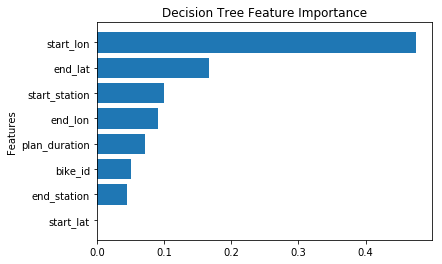

In [101]:
# Get feature importances using the optimal hyperparameters

features = train_X.columns.tolist()
clf_dt = DecisionTreeRegressor(criterion='mse', random_state=1234, max_depth=5 , min_samples_leaf=1)
clf_dt.fit(train_X, train_y)
importances_dt = clf_dt.feature_importances_

idx_dt = np.argsort(importances_dt)
plt.title("Decision Tree Feature Importance")
plt.barh(range(len(idx_dt)), importances_dt[idx_dt])
plt.yticks(range(len(idx_dt)), [features[i] for i in idx_dt])
plt.ylabel("Features")
plt.show()

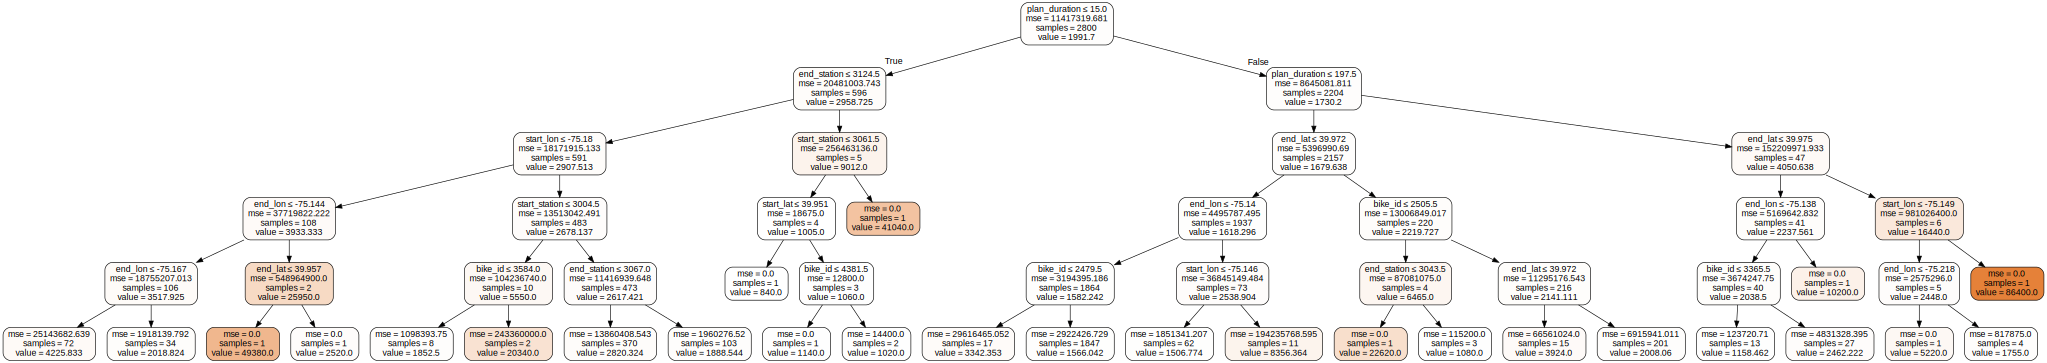

In [102]:
from sklearn import tree
from sklearn.tree import export_graphviz
import graphviz

dot_data = tree.export_graphviz(clf_dt, out_file=None, max_depth=5,
                         feature_names= features,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)  
graph

In [103]:
import operator

# Get the most important features

map_importance_dt = dict(zip(features, importances_dt))
map_importance_dt = sorted(map_importance_dt.items(), key=operator.itemgetter(1), reverse=True)
map_importance_dt

[('start_lon', 0.47464959751242286),
 ('end_lat', 0.16749988640864263),
 ('start_station', 0.10054625752066215),
 ('end_lon', 0.09117717446630459),
 ('plan_duration', 0.07112679156188534),
 ('bike_id', 0.050650609438277455),
 ('end_station', 0.04434701208247244),
 ('start_lat', 2.67100933260651e-06)]

In [104]:
# Get the 4 most importance features with importance score > 0.00065
feature_4 = [item[0] for item in map_importance_dt[:4]]
feature_4

['start_lon', 'end_lat', 'start_station', 'end_lon']

In [105]:
# Create new dataframes for train/test features using only the 4 most important features
train_X4 = train_X.loc[:, feature_4]
test_X4 = test_X.loc[:, feature_4]
train_X4.head(2)

,start_lon,end_lat,start_station,end_lon
0,-75.145638,39.934311,3026.0,-75.160423
1,-75.209869,39.954720,3074.0,-75.183228


In [106]:
# Before moving on, we get the RMSE for train/test sets using ALL feature with optimal hyperparameters

# train RMSE
y_train_predict_dt = clf_dt.predict(train_X)
rmse_ratio_train_dt = compute_rmse_ratio(y_train_predict_dt, train_y)


# test RMSE
y_test_predict_dt = clf_dt.predict(test_X)
rmse_ratio_test_dt = compute_rmse_ratio(y_test_predict_dt, test_y)

print("Tree RMSE Percentage of training set using ALL features: {:.0%}".format(rmse_ratio_train_dt))
print("Tree RMSE Percentage of test set using ALL features: {:.0%}".format(rmse_ratio_test_dt))

# Error Ratio
err_ratio_train_dt = np.median(caculateratio(clf_dt, train_X, train_y).abs_ratio)
err_ratio_test_dt = np.median(caculateratio(clf_dt, test_X, test_y).abs_ratio)
print("Tree Error Percentage of training set using ALL features: {:.0%}".format(err_ratio_train_dt))
print("Tree Error Percentage of test set using ALL features: {:.0%}".format(err_ratio_test_dt))

Tree RMSE Percentage of training set using ALL features: 129%
Tree RMSE Percentage of test set using ALL features: 225%
Tree Error Percentage of training set using ALL features: 48%
Tree Error Percentage of test set using ALL features: 53%


In [107]:
# Secondly, get optimal hyperparameters through GridSearchCV tuning using only 4 most important features

param_grid_tree_4 = {'max_depth': [1,5,10,15,20,25,30],
                     'min_samples_leaf': [1,2,3,4,5]}
grid_tree_4 = GridSearchCV(DecisionTreeRegressor(criterion='mse', random_state=1234), param_grid_tree_4, cv=10)
grid_tree_4.fit(train_X4, train_y)
best_tree_4 = grid_tree_4.best_params_
print('Best parameters for tree using 4 features: {}'.format(best_tree_4))
print('Best score for tree on validation set using 4 features: {:.2f}'.format(grid_tree_4.best_score_))

Best parameters for tree using 4 features: {'max_depth': 1, 'min_samples_leaf': 1}
Best score for tree on validation set using 4 features: -0.03


In [108]:
# Run/Fit the model with optimal hyperparameters using only 7 most important features

clf_dt_4 = DecisionTreeRegressor(criterion='mse', random_state=1234, max_depth=1 , min_samples_leaf=1)
clf_dt_4.fit(train_X4, train_y)

DecisionTreeRegressor(criterion='mse', max_depth=1, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=1234, splitter='best')

In [109]:
# get the RMSE for train/test sets using 4 features with optimal hyperparameters

# train RMSE ratio with 4 features
y_train_predict_dt_4 = clf_dt_4.predict(train_X4)
rmse_ratio_train_dt_4 = compute_rmse_ratio(y_train_predict_dt_4, train_y)

# test RMSE ratio with 4 features
y_test_predict_dt_4 = clf_dt_4.predict(test_X4)
rmse_ratio_test_dt_4 = compute_rmse_ratio(y_test_predict_dt_4, test_y)
print("Tree RMSE Percentage of training set using 4 features: {:.0%}".format(rmse_ratio_train_dt_4))
print("Tree RMSE Percentage of test set using 4 features: {:.0%}".format(rmse_ratio_test_dt_4))

# Error Ratio
err_ratio_train_dt_4 = np.median(caculateratio(clf_dt_4, train_X4, train_y).abs_ratio)
err_ratio_test_dt_4 = np.median(caculateratio(clf_dt_4, test_X4, test_y).abs_ratio)
print("Tree Error Percentage of training set using 4 features: {:.0%}".format(err_ratio_train_dt_4))
print("Tree Error Percentage of test set using 4 features: {:.0%}".format(err_ratio_test_dt_4))

Tree RMSE Percentage of training set using 4 features: 169%
Tree RMSE Percentage of test set using 4 features: 206%
Tree Error Percentage of training set using 4 features: 68%
Tree Error Percentage of test set using 4 features: 68%


Re-run Model after Removing "trips number" variable
--


In [110]:
# Get the new dataframes for train/test set after removing "start_lon" variable, considering it might not be independent
train_X_wt_tn = train_X.drop(["start_lon"], axis=1)
test_X_wt_tn = test_X.drop(["start_lon"], axis=1)
print(train_X_wt_tn.shape)
print(test_X_wt_tn.shape)

(2800, 7)
(65027, 7)


In [111]:
# First, get the optimal hyperparameters through GridSearchCV tuning using ALL features without "start_lon"

# Decision Tree hyperparameters tuning with all features without "start_lon"
param_grid_tree_wt_tn = {'max_depth': [1,5,10,15,20,25,30],
                           'min_samples_leaf': [1,2,3,4,5]}
grid_tree_wt_tn = GridSearchCV(DecisionTreeRegressor(criterion='mse', random_state=1234), param_grid_tree_wt_tn, cv=10)
grid_tree_wt_tn.fit(train_X_wt_tn, train_y)
best_tree_wt_tn = grid_tree_wt_tn.best_params_
print('Tree Best parameters using ALL features without "trips number": {}'.format(best_tree_wt_tn))
print('Tree Best score on validation set using ALL features without "trips number": {:.2f}'.format(grid_tree_wt_tn.best_score_))

Tree Best parameters using ALL features without "trips number": {'max_depth': 1, 'min_samples_leaf': 1}
Tree Best score on validation set using ALL features without "trips number": -0.00


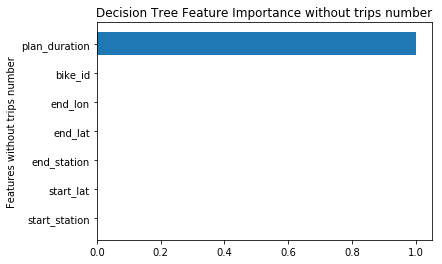

In [112]:
# Get feature importances using the optimal hyperparameters (without trips numbers)

features_wt_tn = train_X_wt_tn.columns.tolist()
clf_dt_wt_tn = DecisionTreeRegressor(criterion='mse', random_state=1234, max_depth=1 , min_samples_leaf=1)
clf_dt_wt_tn.fit(train_X_wt_tn, train_y)
importances_dt_wt_tn = clf_dt_wt_tn.feature_importances_

idx_dt_wt_tn = np.argsort(importances_dt_wt_tn)
plt.title("Decision Tree Feature Importance without trips number")
plt.barh(range(len(idx_dt_wt_tn)), importances_dt_wt_tn[idx_dt_wt_tn])
plt.yticks(range(len(idx_dt_wt_tn)), [features_wt_tn[i] for i in idx_dt_wt_tn])
plt.ylabel("Features without trips number")
plt.show()

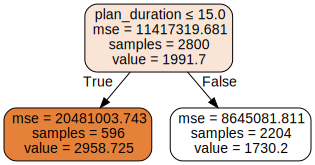

In [113]:
dot_data2 = tree.export_graphviz(clf_dt_wt_tn, out_file=None, max_depth=5,
                         feature_names= features_wt_tn,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data2)  
graph

In [114]:
# Get the most important features without start_lon

map_importance_dt_wt_tn = dict(zip(features_wt_tn, importances_dt_wt_tn))
map_importance_dt_wt_tn = sorted(map_importance_dt_wt_tn.items(), key=operator.itemgetter(1), reverse=True)
map_importance_dt_wt_tn

[('plan_duration', 1.0),
 ('end_lon', 0.0),
 ('end_lat', 0.0),
 ('end_station', 0.0),
 ('bike_id', 0.0),
 ('start_lat', 0.0),
 ('start_station', 0.0)]

In [115]:
# Get the most important 4 features with an importance score larger than 0.04
feature_4_wt_tn = [item[0] for item in map_importance_dt_wt_tn[:4]]
feature_4_wt_tn

['plan_duration', 'end_lon', 'end_lat', 'end_station']

In [116]:
# Create new dataframes for train/test features using only the most 4 important features

train_4_wt_tn = train_X_wt_tn.loc[:, feature_4_wt_tn]
test_4_wt_tn = test_X_wt_tn.loc[:, feature_4_wt_tn]
train_4_wt_tn.head(2)

,plan_duration,end_lon,end_lat,end_station
0,30.0,-75.160423,39.934311,3098.0
1,30.0,-75.183228,39.954720,3022.0


In [119]:
# Before moving on, we get the RMSE for train/test sets using ALL feature (without start_lon) with optimal hyperparameters

# train RMSE
y_train_predict_dt_wt_tn = clf_dt_wt_tn.predict(train_X_wt_tn)
rmse_ratio_train_dt_wt_tn = compute_rmse_ratio(y_train_predict_dt_wt_tn, train_y)

# test RMSE
y_test_predict_dt_wt_tn = clf_dt_wt_tn.predict(test_X_wt_tn)
rmse_ratio_test_dt_wt_tn = compute_rmse_ratio(y_test_predict_dt_wt_tn, test_y)

print("Tree RMSE Percentage of training set using ALL features without start_lon: {:.0%}".format(rmse_ratio_train_dt_wt_tn))
print("Tree RMSE Percentage of test set using ALL features without start_lon: {:.0%}".format(rmse_ratio_test_dt_wt_tn))

# Error Ratio
err_ratio_train_dt_wt_tn = np.median(caculateratio(clf_dt_wt_tn, train_X_wt_tn, train_y).abs_ratio)
err_ratio_test_dt_wt_tn = np.median(caculateratio(clf_dt_wt_tn, test_X_wt_tn, test_y).abs_ratio)
print("Tree Error Percentage of training set using ALL features without start_lon: {:.0%}".format(err_ratio_train_dt_wt_tn))
print("Tree Error Percentage of test set using ALL features without start_lon: {:.0%}".format(err_ratio_test_dt_wt_tn))

Tree RMSE Percentage of training set using ALL features without start_lon: 168%
Tree RMSE Percentage of test set using ALL features without start_lon: 205%
Tree Error Percentage of training set using ALL features without start_lon: 60%
Tree Error Percentage of test set using ALL features without start_lon: 60%


In [120]:
# Secondly, get optimal hyperparameters through GridSearchCV tuning using only 4 most important features

param_grid_tree_4_wt_tn = {'max_depth': [1,5,10,15,20,25,30],
                     'min_samples_leaf': [1,2,3,4,5]}                  
grid_tree_4_wt_tn = GridSearchCV(DecisionTreeRegressor(criterion='mse', random_state=1234), param_grid_tree_4_wt_tn, cv=10)
grid_tree_4_wt_tn.fit(train_4_wt_tn, train_y)
best_tree_4_wt_tn = grid_tree_4_wt_tn.best_params_
print('Tree Best parameters using 4 features without trips number: {}'.format(best_tree_4_wt_tn))
print('Tree Best score on validation set using 4 features without trips number: {:.2f}'.format(grid_tree_4_wt_tn.best_score_))

Tree Best parameters using 4 features without trips number: {'max_depth': 1, 'min_samples_leaf': 1}
Tree Best score on validation set using 4 features without trips number: -0.00


In [121]:
# Run/Fit the model with optimal hyperparameters using only 4 most important features

clf_dt_4_wt_tn = DecisionTreeRegressor(criterion='mse', random_state=1234, max_depth=1 , min_samples_leaf=1)
clf_dt_4_wt_tn.fit(train_4_wt_tn, train_y)

DecisionTreeRegressor(criterion='mse', max_depth=1, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=1234, splitter='best')

In [122]:
# get the RMSE for train/test sets using 4 features with optimal hyperparameters (without start_lon)

# train RMSE with 4 features
y_train_predict_dt_4_wt_tn = clf_dt_4_wt_tn.predict(train_4_wt_tn)
rmse_ratio_train_dt_4_wt_tn = compute_rmse_ratio(y_train_predict_dt_4_wt_tn, train_y)


# test RMSE with 4 features
y_test_predict_dt_4_wt_tn = clf_dt_4_wt_tn.predict(test_4_wt_tn)
rmse_ratio_test_dt_4_wt_tn = compute_rmse_ratio(y_test_predict_dt_4_wt_tn, test_y)
print("Tree RMSE Percentage of training set using 4 features without trips number: {:.0%}".format(rmse_ratio_train_dt_4_wt_tn))
print("Tree RMSE Percentage of test set using 4 features without trips number: {:.0%}".format(rmse_ratio_test_dt_4_wt_tn))


# Error Ratio
err_ratio_train_dt_4_wt_tn = np.median(caculateratio(clf_dt_4_wt_tn, train_4_wt_tn, train_y).abs_ratio)
err_ratio_test_dt_4_wt_tn = np.median(caculateratio(clf_dt_4_wt_tn, test_4_wt_tn, test_y).abs_ratio)
print("Tree Error Percentage of training set using 4 features without trips number: {:.0%}".format(err_ratio_train_dt_4_wt_tn))
print("Tree Error Percentage of test set using 4 features without trips number: {:.0%}".format(err_ratio_test_dt_4_wt_tn))

Tree RMSE Percentage of training set using 4 features without trips number: 168%
Tree RMSE Percentage of test set using 4 features without trips number: 205%
Tree Error Percentage of training set using 4 features without trips number: 60%
Tree Error Percentage of test set using 4 features without trips number: 60%


In [123]:
row_idx = ['Train RMSE perc', 'Test RMSE perc', 'Train err perc', 'Test err perc']
all_features_dt = [rmse_ratio_train_dt, rmse_ratio_test_dt, err_ratio_train_dt, err_ratio_test_dt]
important_features_dt = [rmse_ratio_train_dt_4, rmse_ratio_test_dt_4, err_ratio_train_dt_4, err_ratio_test_dt_4]
all_feature_wt_tn_dt = [rmse_ratio_train_dt_wt_tn, rmse_ratio_test_dt_wt_tn, err_ratio_train_dt_wt_tn, err_ratio_test_dt_wt_tn]
important_features_wt_tn_dt = [rmse_ratio_train_dt_4_wt_tn, rmse_ratio_test_dt_4_wt_tn, err_ratio_train_dt_4_wt_tn, err_ratio_test_dt_4_wt_tn]
tree_metrics_compare = pd.DataFrame({'Metrics': row_idx,
                             'All Features': all_features_dt, 
                             'Top 4 Features': important_features_dt,
                             'All Features w/o tn': all_feature_wt_tn_dt,
                             'Top 4 Features w/o tn': important_features_wt_tn_dt
                              })
cols = ['All Features', 'Top 4 Features', 'All Features w/o tn', 'Top 4 Features w/o tn', 'Metrics']
tree_metrics_compare = tree_metrics_compare[cols]
tree_metrics_compare = tree_metrics_compare.set_index(['Metrics'])
tree_metrics_compare.iloc[0] = (tree_metrics_compare.iloc[0].apply('{:.0%}'.format))
tree_metrics_compare.iloc[1] = (tree_metrics_compare.iloc[1].apply('{:.0%}'.format))
tree_metrics_compare.iloc[2] = (tree_metrics_compare.iloc[2].apply('{:.0%}'.format))
tree_metrics_compare.iloc[3] = (tree_metrics_compare.iloc[3].apply('{:.0%}'.format))
tree_metrics_compare.style.set_properties(**{'text-align': 'right'})

,All Features,Top 4 Features,All Features w/o tn,Top 4 Features w/o tn
Metrics,,,,
Train RMSE perc,129%,169%,168%,168%
Test RMSE perc,225%,206%,205%,205%
Train err perc,48%,68%,60%,60%
Test err perc,53%,68%,60%,60%


Random Fores
==

In [124]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

In [125]:
# # First, get the optimal hyperparameters through GridSearchCV tuning using ALL features

# # Random Forest hyperparameters tuning with all features
# param_grid_forest = {'n_estimators': [10,30,50,100],
#                      'max_depth': [1,5,10,15,20,25,30],
#                      'min_samples_leaf': [1,2,3,4,5]}
# grid_forest = GridSearchCV(RandomForestRegressor(criterion='mse', random_state=1234), param_grid_forest, cv=10)
# grid_forest.fit(train_X, train_y)
# best_RandomForest = grid_forest.best_params_
# print('Best parameters using ALL features: {}'.format(best_RandomForest))
# print('Best score on validation set using ALL features: {:.2f}'.format(grid_forest.best_score_))

Best parameters using ALL features: {'max_depth': 1, 'min_samples_leaf': 1, 'n_estimators': 100}
Best score on validation set using ALL features: 0.99
Best parameters using ALL features: {'max_depth': 10, 'min_samples_leaf': 2, 'n_estimators': 100}
Best score on validation set using ALL features: 0.99

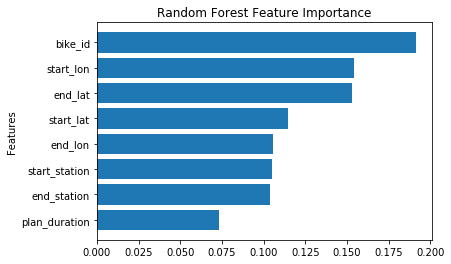

In [126]:
# Get feature importances using the optimal hyperparameters

features = train_X.columns.tolist()
clf_RF = RandomForestRegressor(criterion='mse', random_state=1234, n_estimators=100 , max_depth=10 , min_samples_leaf=2)
clf_RF.fit(train_X, train_y)
importances_RF = clf_RF.feature_importances_

idx = np.argsort(importances_RF)
plt.title("Random Forest Feature Importance")
plt.barh(range(len(idx)), importances_RF[idx])
plt.yticks(range(len(idx)), [features[i] for i in idx])
plt.ylabel("Features")
plt.show()

In [127]:
import operator

# Get the most important features

map_importance = dict(zip(features, importances_RF))
map_importance = sorted(map_importance.items(), key=operator.itemgetter(1), reverse=True)
map_importance

[('bike_id', 0.19124212945961158),
 ('start_lon', 0.15397824074517116),
 ('end_lat', 0.15268255869974792),
 ('start_lat', 0.11460142229602642),
 ('end_lon', 0.10585343500486),
 ('start_station', 0.10489996312950917),
 ('end_station', 0.10369212661552836),
 ('plan_duration', 0.07305012404954543)]

In [128]:
# Get the top 5 most importance features with importance score > 0.00062
feature_5 = [item[0] for item in map_importance[:5]]
feature_5

['bike_id', 'start_lon', 'end_lat', 'start_lat', 'end_lon']

In [130]:
 #Create new dataframes for train/test features using only the most important features
train_X5 = train_X.loc[:, feature_5]
test_X5 = test_X.loc[:, feature_5]
train_X5.head(2)

,bike_id,start_lon,end_lat,start_lat,end_lon
0,3538.0,-75.145638,39.934311,39.941380,-75.160423
1,3554.0,-75.209869,39.954720,39.955109,-75.183228


In [131]:
# Before moving on, we get the RMSE for train/test sets using ALL feature with optimal hyperparameters

# train RMSE
y_train_predict = clf_RF.predict(train_X)
rmse_ratio_train = compute_rmse_ratio(y_train_predict, train_y)


# test RMSE
y_test_predict = clf_RF.predict(test_X)
rmse_ratio_test = compute_rmse_ratio(y_test_predict, test_y)
print("Random Forest RMSE Percentage of training set using ALL features: {:.0%}".format(rmse_ratio_train))
print("Random Forest RMSE Percentage of test set using ALL features: {:.0%}".format(rmse_ratio_test))

# Error Ratio
err_ratio_train = np.median(caculateratio(clf_RF, train_X, train_y).abs_ratio)
err_ratio_test = np.median(caculateratio(clf_RF, test_X, test_y).abs_ratio)
print("Random Forest Error Percentage of training set using ALL features: {:.0%}".format(err_ratio_train))
print("Random Forest Error Percentage of test set using ALL features: {:.0%}".format(err_ratio_test))

Random Forest RMSE Percentage of training set using ALL features: 123%
Random Forest RMSE Percentage of test set using ALL features: 210%
Random Forest Error Percentage of training set using ALL features: 39%
Random Forest Error Percentage of test set using ALL features: 48%


In [132]:
# Secondly, get optimal hyperparameters through GridSearchCV tuning using only 7 most important features

# param_grid_forest_7 = {'n_estimators': [10,30,50,100],
#                      'max_depth': [1,5,10,15,20,25,30],
#                      'min_samples_leaf': [1,2,3,4,5]}
# grid_forest_7 = GridSearchCV(RandomForestRegressor(criterion='mse', random_state=1234), param_grid_forest_7, cv=10)
# grid_forest_7.fit(train_X7, train_y)
# best_RandomForest_7 = grid_forest_7.best_params_
# print('Best parameters using 7 features: {}'.format(best_RandomForest_7))
# print('Best score on validation set using 7 features: {:.2f}'.format(grid_forest_7.best_score_))

Best parameters using 7 features: {'max_depth': 25, 'min_samples_leaf': 4, 'n_estimators': 100}
Best score on validation set using 7 features: 0.99

In [134]:
# Run/Fit the model with optimal hyperparameters using only 7 most important features

clf_RF_5 = RandomForestRegressor(criterion='mse', random_state=1234, n_estimators=100 , max_depth=25 , min_samples_leaf=4)
clf_RF_5.fit(train_X5, train_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=4, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=1234, verbose=0, warm_start=False)

In [135]:
# get the RMSE ratio for train/test sets using 7 features with optimal hyperparameters

# train RMSE ratio with 7 features
y_train_predict_5 = clf_RF_5.predict(train_X5)
rmse_ratio_train_5 = compute_rmse_ratio(y_train_predict_5, train_y)

# test RMSE ratio with 7 features
y_test_predict_5 = clf_RF_5.predict(test_X5)
rmse_ratio_test_5 = compute_rmse_ratio(y_test_predict_5, test_y)
print("Random Forest RMSE Percentage of training set using 5 features: {:.0%}".format(rmse_ratio_train_5))
print("Random Forest RMSE Percentage of test set using 5 features: {:.0%}".format(rmse_ratio_test_5))

# Error Ratio
err_ratio_train_5 = np.median(caculateratio(clf_RF_5, train_X5, train_y).abs_ratio)
err_ratio_test_5 = np.median(caculateratio(clf_RF_5, test_X5, test_y).abs_ratio)
print("Random Forest Error Percentage of training set using 7 features: {:.0%}".format(err_ratio_train_5))
print("Random Forest Error Percentage of test set using 7 features: {:.0%}".format(err_ratio_test_5))

Random Forest RMSE Percentage of training set using 5 features: 140%
Random Forest RMSE Percentage of test set using 5 features: 207%
Random Forest Error Percentage of training set using 7 features: 36%
Random Forest Error Percentage of test set using 7 features: 51%


Re-run Model after Removing bike_id variable

In [136]:
# Get the new dataframes for train/test set after removing "bike_id" variable, considering it might not be independent
train_X_wt_tn = train_X.drop(["bike_id"], axis=1)
test_X_wt_tn = test_X.drop(["bike_id"], axis=1)
print(train_X_wt_tn.shape)
print(test_X_wt_tn.shape)

(2800, 7)
(65027, 7)


In [137]:
# First, get the optimal hyperparameters through GridSearchCV tuning using ALL features without "bike_id"

# Random Forest hyperparameters tuning with all features without "bike_id"
# param_grid_forest_wt_tn = {'n_estimators': [10,30,50,100],
#                      'max_depth': [1,5,10,15,20,25,30],
#                      'min_samples_leaf': [1,2,3,4,5]}
# grid_forest_wt_tn = GridSearchCV(RandomForestRegressor(criterion='mse', random_state=1234), param_grid_forest_wt_tn, cv=10)
# grid_forest_wt_tn.fit(train_X_wt_tn, train_y)
# best_RandomForest_wt_tn = grid_forest_wt_tn.best_params_
# print('Best parameters using ALL features without "trips number": {}'.format(best_RandomForest_wt_tn))
# print('Best score on validation set using ALL features without "trips number": {:.2f}'.format(grid_forest_wt_tn.best_score_))

Best parameters using ALL features without "bike_id": {'max_depth': 25, 'min_samples_leaf': 1, 'n_estimators': 100}
Best score on validation set using ALL features without "bike_id": 0.93

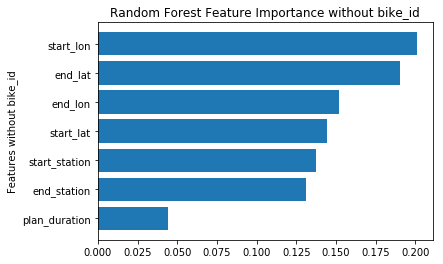

In [144]:
# Get feature importances using the optimal hyperparameters (without bike_id")

features_wt_tn = train_X_wt_tn.columns.tolist()
clf_RF_wt_tn = RandomForestRegressor(criterion='mse', random_state=1234, n_estimators=100 , max_depth=25 , min_samples_leaf=1 )
clf_RF_wt_tn.fit(train_X_wt_tn, train_y)
importances_RF_wt_tn = clf_RF_wt_tn.feature_importances_

idx_wt_tn = np.argsort(importances_RF_wt_tn)
plt.title("Random Forest Feature Importance without bike_id")
plt.barh(range(len(idx_wt_tn)), importances_RF_wt_tn[idx_wt_tn])
plt.yticks(range(len(idx_wt_tn)), [features_wt_tn[i] for i in idx_wt_tn])
plt.ylabel("Features without bike_id")
plt.show()

In [145]:
# Get the most important features without bike_id"

map_importance_wt_tn = dict(zip(features_wt_tn, importances_RF_wt_tn))
map_importance_wt_tn = sorted(map_importance_wt_tn.items(), key=operator.itemgetter(1), reverse=True)
map_importance_wt_tn

[('start_lon', 0.20084792724735887),
 ('end_lat', 0.19037239704318712),
 ('end_lon', 0.1518041740245496),
 ('start_lat', 0.14412560561414703),
 ('start_station', 0.1370989887617678),
 ('end_station', 0.13137905811105663),
 ('plan_duration', 0.04437184919793308)]

In [140]:
# Get the most important 6 features with an importance score larger than 0.03
feature_6 = [item[0] for item in map_importance_wt_tn[:6]]
feature_6


['start_lon',
 'end_lat',
 'end_lon',
 'start_lat',
 'start_station',
 'end_station']

In [141]:
# Create new dataframes for train/test features using only the most 6 important features

train_X6 = train_X_wt_tn.loc[:, feature_6]
test_X6 = test_X_wt_tn.loc[:, feature_6]
train_X6.head(2)

,start_lon,end_lat,end_lon,start_lat,start_station,end_station
0,-75.145638,39.934311,-75.160423,39.941380,3026.0,3098.0
1,-75.209869,39.954720,-75.183228,39.955109,3074.0,3022.0


In [147]:
# Before moving on, we get the RMSE ratio for train/test sets using ALL feature (without bike_id") with optimal hyperparameters

# train RMSE ratio
y_train_predict_wt_tn = clf_RF_wt_tn.predict(train_X_wt_tn)
rmse_ratio_train_wt_tn = compute_rmse_ratio(y_train_predict_wt_tn, train_y)

# test RMSE ratio
y_test_predict_wt_tn = clf_RF_wt_tn.predict(test_X_wt_tn)
rmse_ratio_test_wt_tn = compute_rmse_ratio(y_test_predict_wt_tn, test_y)
print("Random Forest RMSE Percentage of training set using ALL features without bike_id: {:.0%}".format(rmse_ratio_train_wt_tn))
print("Random Forest RMSE Percentage of test set using ALL features without bike_id: {:.0%}".format(rmse_ratio_test_wt_tn))

# Error Ratio
err_ratio_train_wt_tn = np.median(caculateratio(clf_RF_wt_tn, train_X_wt_tn, train_y).abs_ratio)
err_ratio_test_wt_tn = np.median(caculateratio(clf_RF_wt_tn, test_X_wt_tn, test_y).abs_ratio)
print("Random Forest Error Percentage of training set using ALL features without bike_id: {:.0%}".format(err_ratio_train_wt_tn))
print("Random Forest Error Percentage of test set using ALL features without bike_id: {:.0%}".format(err_ratio_test_wt_tn))

Random Forest RMSE Percentage of training set using ALL features without bike_id: 84%
Random Forest RMSE Percentage of test set using ALL features without bike_id: 217%
Random Forest Error Percentage of training set using ALL features without bike_id: 16%
Random Forest Error Percentage of test set using ALL features without bike_id: 38%


In [148]:
# Secondly, get optimal hyperparameters through GridSearchCV tuning using only 8 most important features

# param_grid_forest_6 = {'n_estimators': [10,30,50,100],
#                      'max_depth': [1,5,10,15,20,25,30],
#                      'min_samples_leaf': [1,2,3,4,5]}
# grid_forest_6 = GridSearchCV(RandomForestRegressor(criterion='mse', random_state=1234), param_grid_forest_6, cv=10)
# grid_forest_6.fit(train_X6, train_y)
# best_RandomForest_6 = grid_forest_6.best_params_
# print('Random Forest Best parameters using 6 features without trips number: {}'.format(best_RandomForest_6))
# print('Random Forest Best score on validation set using 6 features without trips number: {:.2f}'.format(grid_forest_6.best_score_))

Random Forest Best parameters using 6 features without trips number: {'max_depth': 15, 'min_samples_leaf': 3, 'n_estimators': 100}
Random Forest Best score on validation set using 6 features without trips number: 0.91

In [149]:
# Run/Fit the model with optimal hyperparameters using only 6 most important features

clf_RF_6 = RandomForestRegressor(criterion='mse', random_state=1234, n_estimators=100 , max_depth=15 , min_samples_leaf=3)
clf_RF_6.fit(train_X6, train_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=3, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=1234, verbose=0, warm_start=False)

In [150]:
# get the RMSE ratio for train/test sets using 6 features with optimal hyperparameters (without bike_id)

# train RMSE ratito with 6 features
y_train_predict_6 = clf_RF_6.predict(train_X6)
rmse_ratio_train_6 = compute_rmse_ratio(y_train_predict_6, train_y)

# test RMSE ratio with 6 features
y_test_predict_6 = clf_RF_6.predict(test_X6)
rmse_ratio_test_6 = compute_rmse_ratio(y_test_predict_6, test_y)
print("Random Forest RMSE Percentage of training set using 6 features without bike_id: {:.0%}".format(rmse_ratio_train_6))
print("Random Forest RMSE Percentage of test set using 6 features without bike_id: {:.0%}".format(rmse_ratio_test_6))

# Error Ratio
err_ratio_train_6 = np.median(caculateratio(clf_RF_6, train_X6, train_y).abs_ratio)
err_ratio_test_6 = np.median(caculateratio(clf_RF_6, test_X6, test_y).abs_ratio)
print("Random Forest Error Percentage of training set using 6 features without bike_id: {:.0%}".format(err_ratio_train_6))
print("Random Forest Error Percentage of test set using 6 features without bike_id: {:.0%}".format(err_ratio_test_6))

Random Forest RMSE Percentage of training set using 6 features without bike_id: 140%
Random Forest RMSE Percentage of test set using 6 features without bike_id: 209%
Random Forest Error Percentage of training set using 6 features without bike_id: 33%
Random Forest Error Percentage of test set using 6 features without bike_id: 44%


In [152]:
row_idx = ['Train RMSE perc', 'Test RMSE perc', 'Train err perc', 'Test err perc']
all_features_RF = [rmse_ratio_train, rmse_ratio_test, err_ratio_train, err_ratio_test]
important_features_RF = [rmse_ratio_train_5, rmse_ratio_test_5, err_ratio_train_5, err_ratio_test_5]
all_feature_wt_tn_RF = [rmse_ratio_train_wt_tn, rmse_ratio_test_wt_tn, err_ratio_train_wt_tn, err_ratio_test_wt_tn]
important_features_wt_tn_RF = [rmse_ratio_train_6, rmse_ratio_test_6, err_ratio_train_6, err_ratio_test_6]
forest_metrics_compare = pd.DataFrame({'Metrics': row_idx,
                             'All Features': all_features_RF, 
                             'Top 7 Features': important_features_RF,
                             'All Features w/o tn': all_feature_wt_tn_RF,
                             'Top 6 Features w/o tn': important_features_wt_tn_RF
                              })
cols = ['All Features', 'Top 7 Features', 'All Features w/o tn', 'Top 6 Features w/o tn', 'Metrics']
forest_metrics_compare = forest_metrics_compare[cols]
forest_metrics_compare = forest_metrics_compare.set_index(['Metrics'])
forest_metrics_compare.iloc[0] = (forest_metrics_compare.iloc[0].apply('{:.0%}'.format))
forest_metrics_compare.iloc[1] = (forest_metrics_compare.iloc[1].apply('{:.0%}'.format))
forest_metrics_compare.iloc[2] = (forest_metrics_compare.iloc[2].apply('{:.0%}'.format))
forest_metrics_compare.iloc[3] = (forest_metrics_compare.iloc[3].apply('{:.0%}'.format))
forest_metrics_compare.style.set_properties(**{'text-align': 'right'})

,All Features,Top 7 Features,All Features w/o tn,Top 6 Features w/o tn
Metrics,,,,
Train RMSE perc,123%,140%,84%,140%
Test RMSE perc,210%,207%,217%,209%
Train err perc,39%,36%,16%,33%
Test err perc,48%,51%,38%,44%


the network
==

In [167]:
# Save data for approximately the last 21 days 
test_data = df[-21*24:]

# Now remove the test data from the data set 
data = df[:-21*24]

# Separate the data into features and targets
target_fields = ['duration']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

In [168]:
# Hold out the last 60 days or so of the remaining data as a validation set
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

In [172]:
from network import NeuralNetwork



In [173]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

In [ ]:
import sys

####################
### Set the hyperparameters in you myanswers.py file ###
####################

from network import iterations, learning_rate, hidden_nodes, output_nodes


N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for ii in range(iterations):
    # Go through a random batch of 128 records from the training data set
    batch = np.random.choice(train_features.index, size=128)
    X, y = train_features.ix[batch].values, train_targets.ix[batch]['duration']
                             
    network.train(X, y)
    
    # Printing out the training progress
    train_loss = MSE(network.run(train_features).T, train_targets['duration'].values)
    val_loss = MSE(network.run(val_features).T, val_targets['duration'].values)
    sys.stdout.write("\rProgress: {:2.1f}".format(100 * ii/float(iterations)) \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    sys.stdout.flush()
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

/Users/melike/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


Progress: 4.7% ... Training loss: inf ... Validation loss: 1.35251

/Users/melike/anaconda2/lib/python2.7/site-packages/numpy/core/_methods.py:75: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


Progress: 4.8% ... Training loss: inf ... Validation loss: inf

/Users/melike/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in square
  


Progress: 4.8% ... Training loss: inf ... Validation loss: inf

network.py:99: RuntimeWarning: invalid value encountered in multiply
  hidden_error_term = hidden_error * hidden_outputs * (1 - hidden_outputs)


Progress: 14.0% ... Training loss: nan ... Validation loss: nan

In [ ]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
_ = plt.ylim()

Check out your prediction
--

In [ ]:
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['duration']
predictions = network.run(test_features).T*std + mean
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['duration']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.ix[test_data.index]['bike_id'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)